# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

Done by Group7 : Jiacong Yuan ( jy3459 ) and Wenjie Lin ( wl2792 )

## Project Setup

In [3]:
# all import statements needed for the project, for example:

import os

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import geopandas as gpd
import sqlite3
import numpy as np
import math
from bs4 import BeautifulSoup
import re
from functools import partial
from sqlalchemy import text

In [4]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = ""
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [7]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones and Lookup Coordinates
This section demonstrates how to load a geospatial dataset representing NYC taxi zones and find the geographic coordinates (latitude and longitude) for a specific taxi zone using its unique Location ID.



### Step 1: Load the Taxi Zones Data

#### **What Happens in This Step**

1. **Input File Path**  
   - The file path for the shapefile is specified. It should contain a map of NYC taxi zones, each associated with a unique `LocationID`.

2. **Check for File Existence**  
   - The program first verifies if the shapefile exists at the specified path. If the file is missing, it raises an error and stops the execution.

3. **Load the Shapefile**  
   - The file is loaded into a GeoDataFrame using GeoPandas, which is specialized for working with spatial data.

4. **Validate the Data**  
   - It ensures that the shapefile contains the required column `LocationID` (a unique identifier for each taxi zone).  


In [12]:
def load_taxi_zones(shapefile_path):
    """
    Load the Taxi Zone shapefile into a GeoDataFrame.

    Parameters:
        shapefile_path (str): Path to the Taxi Zone shapefile.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing Taxi Zone data.

    Raises:
        FileNotFoundError: If the shapefile does not exist.
        RuntimeError: If there is an error loading the shapefile.
    """
    if not os.path.exists(shapefile_path):
        raise FileNotFoundError(f"Shapefile not found at: {shapefile_path}")

    try:
        taxi_zones_gdf = gpd.read_file(shapefile_path)

        # Ensure required columns exist
        if 'LocationID' not in taxi_zones_gdf.columns:
            raise ValueError("Shapefile must contain 'LocationID' column.")

        # Ensure CRS is EPSG:4326
        if taxi_zones_gdf.crs is None or taxi_zones_gdf.crs.to_epsg() != 4326:
            taxi_zones_gdf = taxi_zones_gdf.to_crs(epsg=4326)

        return taxi_zones_gdf

    except Exception as e:
        raise RuntimeError(f"Failed to load shapefile: {e}")


In [14]:
TAXI_ZONES_DIR = r"C:\Users\wenji\OneDrive\Project\taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
if not os.path.exists(TAXI_ZONES_SHAPEFILE):
    raise FileNotFoundError(f"Taxi Zone Shapefile not found at: {TAXI_ZONES_SHAPEFILE}")
else:
    print(f"Taxi Zone Shapefile found at: {TAXI_ZONES_SHAPEFILE}")

Taxi Zone Shapefile found at: C:\Users\wenji\OneDrive\Project\taxi_zones/taxi_zones.shp


In [16]:
try:
    taxi_zones_gdf = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
    print(taxi_zones_gdf.head())
except FileNotFoundError as e:
    print(f"File not found: {e}")
except RuntimeError as e:
    print(f"Error loading shapefile: {e}")

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((-74.18445 40.695, -74.18449 40.6951,...  
1         Queens  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2          Bronx  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3      Manhattan  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4  Staten Island  POLYGON ((-74.17422 40.56257, -74.17349 40.562...  


### Step 2: Lookup Coordinates for a Taxi Zone

#### **What Happens in This Step**

1. **Input Location ID**  
   - The user provides a `LocationID`, a unique identifier for a specific taxi zone.

2. **Filter the Data**  
   - The program searches the GeoDataFrame to find the zone with the matching `LocationID`.

3. **Extract the Geometry**  
   - Once the zone is identified, its shape (geometry) is used to calculate the centroid (center point).

4. **Output Coordinates**  
   - The program returns the coordinates (latitude and longitude) of the centroid.  
   - If the `LocationID` is not found in the data, it returns `None`.


In [19]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Lookup the latitude and longitude for a given Taxi Zone Location ID.

    Parameters:
        zone_loc_id (int): Taxi Zone Location ID.
        loaded_taxi_zones (gpd.GeoDataFrame): GeoDataFrame containing Taxi Zone data.

    Returns:
        tuple: (latitude, longitude) of the centroid of the zone geometry, 
               or None if the Location ID is not found.
    """
    try:
        # Filter GeoDataFrame for the given Location ID
        zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]
        
        if zone.empty:
            return None  # Return None if the Location ID is not found
        
        # Extract the geometry and calculate the centroid
        centroid = zone.iloc[0].geometry.centroid
        
        # Return the centroid's coordinates as (latitude, longitude)
        return centroid.y, centroid.x  # (latitude, longitude)
    
    except Exception as e:
        raise RuntimeError(f"Error looking up coordinates for Zone ID {zone_loc_id}: {e}")



In [21]:
# Lookup coordinates for a specific Taxi Zone ID
zone_id = 263
coords = lookup_coords_for_taxi_zone_id(zone_id, taxi_zones_gdf)

if coords:
    print(f"Coordinates for Zone ID {zone_id}: Latitude = {coords[0]}, Longitude = {coords[1]}")
else:
    print(f"Zone ID {zone_id} not found in the Taxi Zone data.")

Coordinates for Zone ID 263: Latitude = 40.77876585543437, Longitude = -73.951009874818


### Calculate Sample Size
This section demonstrates how to calculate the appropriate sample size for analyzing a dataset using Cochran's formula, specifically tailored for finite populations like taxi trip data.



To calculate the required sample size, we use **Cochran's formula**, which accounts for the population size and desired confidence level, margin of error, and proportion.

1. **Input Parameters**  
   - Population size: Total number of records in the dataset.  
   - Confidence level: Typically 90%, 95%, or 99% (e.g., 95% confidence).  
   - Margin of error: The acceptable error range for the results (e.g., ±5%).  
   - Proportion: Estimated proportion of the population with the desired attribute (default is 0.5 for maximum variability).

2. **Cochran's Formula for Infinite Populations**  
   - The formula calculates the sample size assuming an infinite population:
     $$
     n_0 = \frac{Z^2 \cdot p \cdot (1 - p)}{E^2}
     $$
     Where:
     - \( n_0 \): Initial sample size for infinite population.
     - \( Z \): Z-score based on the confidence level (e.g., 1.96 for 95% confidence).
     - \( p \): Proportion of the population (default 0.5).  
     - \( E \): Margin of error (e.g., 0.05 for ±5%).

3. **Adjust for Finite Population Size**  
   - If the population is finite, the sample size is adjusted using the correction formula:
     $$
     n = \frac{n_0}{1 + \frac{n_0 - 1}{N}}
     $$
     Where:
     - \( n \): Final sample size for the finite population.  
     - \( N \): Total population size.

4. **Output**  
   - The final sample size is rounded up to ensure a whole number of samples is selected.  
   - This ensures the sample is statistically valid for the specified parameters.


In [25]:
def calculate_sample_size(population, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    """
    Calculate the sample size using Cochran's formula for finite populations.

    Parameters:
        population (int): The size of the population (e.g., number of trips in a month).
        confidence_level (float): The confidence level (default is 0.95 for 95% confidence).
        margin_of_error (float): The margin of error (default is 0.05 for ±5% error).
        proportion (float): The estimated proportion of the population with the desired attribute (default is 0.5).

    Returns:
        int: The calculated sample size.
    """
    # Z-score for the given confidence level
    z_scores = {0.9: 1.645, 0.95: 1.96, 0.99: 2.576}
    if confidence_level not in z_scores:
        raise ValueError("Unsupported confidence level. Use 0.9, 0.95, or 0.99.")
    Z = z_scores[confidence_level]
    
    # Cochran's formula for an infinite population
    n_0 = (Z**2 * proportion * (1 - proportion)) / (margin_of_error**2)
    
    # Adjust for finite population size
    if population < n_0:
        sample_size = population  # If the population is small, the entire dataset is needed
    else:
        sample_size = n_0 / (1 + (n_0 - 1) / population)
    
    return math.ceil(sample_size)

In [27]:
yellow_taxi_df = pd.read_parquet(r"C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-01.parquet")

population_size = len(yellow_taxi_df)
print(f"Population size: {population_size}")

Population size: 6405008


### Common Functions

### Step 1: Define a function `get_all_urls_from_tlc_page` that extracts all URLs from a specified webpage.

1. **Input**:  
   - The function takes a webpage URL (`taxi_page`) as input.

2. **Request the Webpage**:  
   - Using the `requests` library, the HTML content of the page is fetched.

3. **Parse the HTML**:  
   - The HTML content is parsed using `BeautifulSoup` from the `bs4` library.

4. **Extract URLs**:  
   - All anchor (`<a>`) tags with `href` attributes are located, and their links are extracted into a list.

5. **Output**:  
   - A list of extracted URLs is returned.

In [31]:
def get_all_urls_from_tlc_page(taxi_page):
    """
    Extract all URLs from the TLC trip record data page.

    Parameters:
        taxi_page (str): URL of the TLC webpage.

    Returns:
        list: A list of all extracted URLs from the webpage.
    """
    try:
        # Request the HTML page
        response = requests.get(taxi_page)
        response.raise_for_status()  # Check if the request was successful

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all links on the page
        links = [a['href'] for a in soup.find_all('a', href=True)]

        return links
    except Exception as e:
        raise RuntimeError(f"Error fetching or parsing the TLC page: {e}")



In [33]:
# TLC Trip Record Data Page URL
URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

# Extract all URLs
try:
    all_urls = get_all_urls_from_tlc_page(URL)
    print(f"Extracted {len(all_urls)} URLs:")
    for url in all_urls:  # Print all links in  URL
        print(url)
except RuntimeError as e:
    print(e)


Extracted 563 URLs:
http://www1.nyc.gov
/311/index.page
/home/search/index.page
#
/site/tlc/index.page
http://www1.nyc.gov/home/text-size.page
#
/site/tlc/index.page
/site/tlc/about/about-tlc.page
/site/tlc/passengers/your-ride.page
/site/tlc/drivers/get-a-drivers-license.page
/site/tlc/vehicles/get-a-vehicle-license.page
/site/tlc/businesses/yellow-cab.page
/site/tlc/tlc-online/tlc-online.page
/site/tlc/about/about-tlc.page
/site/tlc/about/data-and-research.page
/site/tlc/about/tlc-initiatives.page
/site/tlc/about/contact-tlc.page
/site/tlc/about/data.page
/site/tlc/about/pilot-programs.page
/site/tlc/about/industry-reports.page
/site/tlc/about/tlc-trip-record-data.page
/site/tlc/about/request-data.page
#
#
#
#
#
javascript:expandAll();
javascript:collapseAll();
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet 
https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet 
https://d37ci6vzurychx.cloudfront.net/trip-data/fhv_tripdata_2024

### Step 2: The `filter_parquet_urls` function uses regular expressions to match and filter URLs for Yellow Taxi and HVFHV datasets. 

1. **Input**:  
   - A list of URLs (`all_urls`) extracted from the TLC page.

2. **Regular Expressions**:  
   - Patterns are defined to match Parquet files for:
     - Yellow Taxi datasets (`yellow_tripdata`).
     - HVFHV datasets (`fhvhv_tripdata`).
   - The date ranges included are:
     - 2020 (January to December).
     - 2021–2023 (all months).
     - 2024 (January to August).

3. **Filter URLs**:  
   - URLs matching the patterns are extracted into separate lists.

4. **Output**:  
   - Two lists: one for Yellow Taxi dataset links, and another for HVFHV dataset links.

In [36]:
def filter_parquet_urls(all_urls):
    """
    Filter Yellow Taxi and HVFHV Parquet file URLs for the specified date range.

    Parameters:
        all_urls (list): A list of all URLs extracted from the TLC page.

    Returns:
        tuple: Two lists containing filtered URLs for Yellow Taxi and HVFHV datasets.
    """
    # Compile regular expressions to match the desired Parquet files
    yellow_taxi_pattern = re.compile(
        r'yellow_tripdata_2020-(0[1-9]|1[0-2])\.parquet|'
        r'yellow_tripdata_202[1-3]-\d{2}\.parquet|'
        r'yellow_tripdata_2024-(0[1-8])\.parquet'
    )
    fhvhv_pattern = re.compile(
        r'fhvhv_tripdata_2020-(0[1-9]|1[0-2])\.parquet|'
        r'fhvhv_tripdata_202[1-3]-\d{2}\.parquet|'
        r'fhvhv_tripdata_2024-(0[1-8])\.parquet'
    )

    # Filter URLs using the patterns
    yellow_taxi_links = [url for url in all_urls if yellow_taxi_pattern.search(url)]
    fhvhv_links = [url for url in all_urls if fhvhv_pattern.search(url)]

    return yellow_taxi_links, fhvhv_links


In [38]:
# Example: Extract URLs from the TLC page
all_urls = get_all_urls_from_tlc_page("https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page")

# Filter the Parquet file URLs
yellow_taxi_links, fhvhv_links = filter_parquet_urls(all_urls)

# Print the filtered links
print("Yellow Taxi Links:")
for link in yellow_taxi_links:
    print(link)

print("\nFHVHV Links:")
for link in fhvhv_links:
    print(link)
    

Yellow Taxi Links:
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet 
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet 
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet 
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-04.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-06.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-08.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet
https://d37ci6vzur

### Step 3: Define the Download Function

The `download_files` function takes a list of file URLs and downloads them to a specified directory.

1. **Input Parameters**:
   - `file_links`: A list of URLs for the files to download.
   - `save_dir`: Path to the directory where files will be saved.

2. **Ensure Save Directory Exists**:
   - The function creates the directory if it does not already exist using `os.makedirs`.

3. **Download Files**:
   - For each URL in `file_links`:
     - The file name is extracted from the URL.
     - The file is downloaded using `requests` and saved locally in the specified directory.
     - The function prints the status of each download.

4. **Handle Errors**:
   - If any error occurs during the download, an appropriate error message is printed.

5. **Use Download Function**:
   - we use download function to download parquet file from yellow_taxi_links, fhvhv_links



In [41]:
def download_files(file_links, save_dir):
    """
    Downloads files from a list of URLs and saves them to a specified directory.

    Args:
        file_links (list): List of URLs for the files to download.
        save_dir (str): Path to the directory where files will be saved.

    Returns:
        None
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    for link in file_links:
        try:
            # Extract file name from the URL
            file_name = link.split("/")[-1]
            file_path = os.path.join(save_dir, file_name)
            
            # Download the file
            print(f"Downloading {file_name}...")
            response = requests.get(link, stream=True)
            response.raise_for_status()  # Raise an error for bad status codes

            # Save the file locally
            with open(file_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192):
                    file.write(chunk)
            print(f"Downloaded: {file_name}")
        
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {link}: {e}")



In [ ]:
file_links = [yellow_taxi_links]

save_dir = "C:\Users\wenji\OneDrive\Project\downloads yellow taxi"
download_files(file_links, save_dir)

In [ ]:
file_links = fhvhv_links  # Use the list directly, assuming fhvhv_links is already a list of URLs
save_dir = "C:\Users\wenji\OneDrive\Project\downloads_HVFHV"

download_files(file_links, save_dir)


### Step 4: Define the Sampling Function for a Single Parquet File

The `sample_parquet_file` function loads a Parquet file, calculates the required sample size using Cochran's formula, extracts a random sample of rows, and saves the sampled data to a new Parquet file.

1. **Process**:
   - Loads the dataset from the specified Parquet file.
   - Calculates the sample size using the `calculate_sample_size` function.
   - Extracts a random sample of rows if the sample size is less than the population size. Otherwise, uses the full dataset.
   - Saves the sampled data as a new Parquet file in the output directory.

2. **Output**:
   - A new Parquet file containing the sampled dataset.

In [45]:
def sample_parquet_file(parquet_file, output_directory="sampled yellow taxi", confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    """
    Load a Parquet file, calculate a sample size, extract a random sample,
    and save it to a new Parquet file in the 'sampled yellow taxi' folder.

    Parameters:
        parquet_file (str): Path to the input Parquet file.
        output_directory (str): Directory to save the sampled Parquet file.
        confidence_level (float): Confidence level for sample size calculation (default is 0.95).
        margin_of_error (float): Margin of error for sample size calculation (default is 0.05).
        proportion (float): Estimated proportion of the population with the desired attribute (default is 0.5).
    """
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Load the dataset
    print(f"Loading Parquet file: {parquet_file}")
    df = pd.read_parquet(parquet_file)

    # Calculate sample size
    population_size = len(df)
    sample_size = calculate_sample_size(population_size, confidence_level, margin_of_error, proportion)
    print(f"Population size: {population_size}, Sample size: {sample_size}")

    # If the sample size is larger than the population, use the full dataset
    if sample_size >= population_size:
        print("Sample size is larger than or equal to the population. Using the entire dataset.")
        sampled_df = df
    else:
        # Extract random sample
        print(f"Sampling {sample_size} rows from the dataset...")
        sampled_df = df.sample(n=sample_size, random_state=42)

    # Save the sampled dataset
    file_name = os.path.basename(parquet_file)
    output_file = os.path.join(output_directory, os.path.splitext(file_name)[0] + "_sample.parquet")
    print(f"Saving sampled data to: {output_file}")
    sampled_df.to_parquet(output_file, index=False)


### Step 5: Apply Sampling to All Files in a Directory

The `sample_all_parquet_files` function applies the `sample_parquet_file` function to all Parquet files in a specified directory.

1. **Process**:
   - Ensures the `output_directory` exists or creates it.
   - Iterates through all files in the `input_directory`.
   - Identifies Parquet files by their `.parquet` extension.
   - Applies the `sample_parquet_file` function to each Parquet file.

2. **Output**:
   - Sampled datasets are saved as new Parquet files in the `output_directory`, with filenames suffixed by `_sample.parquet`.

In [48]:
def sample_all_parquet_files(input_directory, output_directory="sampled yellow taxi", confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    """
    Apply sample_parquet_file to all Parquet files in a directory.

    Parameters:
        input_directory (str): Directory containing the Parquet files.
        output_directory (str): Directory to save the sampled Parquet files.
        confidence_level (float): Confidence level for sample size calculation (default is 0.95).
        margin_of_error (float): Margin of error for sample size calculation (default is 0.05).
        proportion (float): Estimated proportion of the population with the desired attribute (default is 0.5).
    """
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Iterate through all files in the input directory
    for file_name in os.listdir(input_directory):
        if file_name.endswith(".parquet"):
            # Construct the full file path
            file_path = os.path.join(input_directory, file_name)
            print(f"Processing file: {file_path}")
            
            # Apply sampling to each file
            try:
                sample_parquet_file(file_path, output_directory, confidence_level, margin_of_error, proportion)
            except Exception as e:
                print(f"Failed to process file {file_name}: {e}")


In [46]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads yellow taxi"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled yellow taxi"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)


Processing file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-01.parquet
Population size: 6405008, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-02.parquet
Population size: 6299367, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_tripdata_2020-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads yellow taxi\yellow_

### Process Taxi data

### Step 1: Define the Cleaning Function

The `clean_parquet_columns` function reads a Parquet file, selects specific columns, and returns the cleaned DataFrame.

1. **Input**:
   - `parquet_file`: Path to the Parquet file that needs cleaning.

2. **Process**:
   - Reads the Parquet file into a Pandas DataFrame.
   - Specifies the relevant columns to keep:
     - `'tpep_pickup_datetime'`: Pickup time.
     - `'tpep_dropoff_datetime'`: Dropoff time.
     - `'passenger_count'`: Number of passengers.
     - `'trip_distance'`: Distance of the trip.
     - `'PULocationID'`: Pickup location ID.
     - `'DOLocationID'`: Dropoff location ID.
     - `'tip_amount'`: Amount of tip given.
     - `'total_amount'`: Total amount charged.
     - `'congestion_surcharge'`: Additional congestion surcharge.
   - Filters the DataFrame to include only these columns.

3. **Output**:
   - A cleaned DataFrame containing only the specified columns.

4. **Error Handling**:
   - If an error occurs during processing, the function prints the error message and returns `None`.

In [51]:
def clean_parquet_columns(parquet_file):
    """
    Read a Parquet file, keep only relevant columns, and return the cleaned DataFrame.

    Parameters:
    - parquet_file (str): Path to the Parquet file.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """
    try:
        # Read the Parquet file
        df = pd.read_parquet(parquet_file)

        # Specify the columns to keep
        columns_to_keep = [
            'tpep_pickup_datetime', 'tpep_dropoff_datetime',
            'passenger_count', 'trip_distance',
            'PULocationID', 'DOLocationID', 'tip_amount', 'total_amount', 'congestion_surcharge'
        ]

        # Filter the DataFrame to keep only the specified columns
        df_cleaned = df[columns_to_keep]
        return df_cleaned

    except Exception as e:
        print(f"Error processing the Parquet file: {e}")
        return None


In [53]:
file= r"C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-02_sample.parquet"
clean = clean_parquet_columns(file)
print(clean.head(10))

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2020-02-19 19:37:08   2020-02-19 19:42:59              1.0           1.24   
1  2020-02-27 12:17:32   2020-02-27 12:26:00              1.0           0.86   
2  2020-02-06 14:38:29   2020-02-06 14:44:46              1.0           1.40   
3  2020-02-01 12:10:41   2020-02-01 12:22:25              1.0           1.80   
4  2020-02-14 19:18:29   2020-02-14 19:37:45              3.0           1.85   
5  2020-02-17 16:02:28   2020-02-17 16:09:40              1.0           1.90   
6  2020-02-08 12:38:37   2020-02-08 12:51:12              1.0           1.74   
7  2020-02-23 19:40:40   2020-02-23 19:48:55              1.0           1.31   
8  2020-02-01 04:43:14   2020-02-01 04:53:06              1.0           2.10   
9  2020-02-06 17:27:39   2020-02-06 17:43:09              1.0           3.13   

   PULocationID  DOLocationID  tip_amount  total_amount  congestion_surcharge  
0           237           236        0.

### Step 2: Define the Normalization Function

The `normalize_column_names` function modifies column names in the following ways:
1. **Convert to Lowercase**:
   - Ensures all column names are in lowercase for uniformity.
2. **Remove Special Characters**:
   - Strips out non-alphanumeric characters except for underscores.
3. **Replace Spaces with Underscores**:
   - Converts spaces and other whitespace to underscores.
4. **Strip Leading and Trailing Spaces**:
   - Removes any extra spaces around column names.

#### **Input**:
- `df`: A Pandas DataFrame with column names to be normalized.

#### **Output**:
- A DataFrame with normalized column names.


In [56]:
def normalize_column_names(df):
    """
    Normalize column names in a DataFrame by:
    - Converting to lowercase
    - Replacing spaces and special characters with underscores

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: The DataFrame with normalized column names.
    """
    # Normalize column names
    df.columns = (
        df.columns
        .str.strip()               # Remove leading/trailing spaces
        .str.lower()               # Convert to lowercase
        .str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
        .str.replace(r'\s+', '_', regex=True)     # Replace spaces with underscores
    )
    return df


In [58]:
clean1 = normalize_column_names(clean)
print(clean1.head(10))

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2020-02-19 19:37:08   2020-02-19 19:42:59              1.0           1.24   
1  2020-02-27 12:17:32   2020-02-27 12:26:00              1.0           0.86   
2  2020-02-06 14:38:29   2020-02-06 14:44:46              1.0           1.40   
3  2020-02-01 12:10:41   2020-02-01 12:22:25              1.0           1.80   
4  2020-02-14 19:18:29   2020-02-14 19:37:45              3.0           1.85   
5  2020-02-17 16:02:28   2020-02-17 16:09:40              1.0           1.90   
6  2020-02-08 12:38:37   2020-02-08 12:51:12              1.0           1.74   
7  2020-02-23 19:40:40   2020-02-23 19:48:55              1.0           1.31   
8  2020-02-01 04:43:14   2020-02-01 04:53:06              1.0           2.10   
9  2020-02-06 17:27:39   2020-02-06 17:43:09              1.0           3.13   

   pulocationid  dolocationid  tip_amount  total_amount  congestion_surcharge  
0           237           236        0.

### Step 3: Define the Processing Function
This section explains how to process a taxi trip dataset by cleaning, mapping location IDs to geographic coordinates, and filtering the data based on a bounding box.
The `process_taxi_data_from_df` function processes a taxi trip dataset in the following steps:


1. **Processing Steps**:
   - **Normalize Column Names**:
     - Standardizes column names to lowercase and replaces special characters with underscores.
   - **Filter Invalid Location IDs**:
     - Removes rows where `PULocationID` or `DOLocationID` is missing or outside the valid range (1–263).
   - **Map Location IDs to Coordinates**:
     - Maps pickup and dropoff location IDs to their respective latitude and longitude using the Taxi Zone GeoDataFrame.
   - **Split Coordinates**:
     - Adds separate columns for pickup and dropoff latitude/longitude.
   - **Filter Rows by Bounding Box**:
     - Keeps rows with valid pickup and dropoff coordinates within the defined geographic bounding box.

2. **Output**:
   - A cleaned and filtered DataFrame ready for further analysis.

In [61]:
def process_taxi_data_from_df(df, loaded_taxi_zones, lat_min=40.560445, lon_min=-74.242330, lat_max=40.908524, lon_max=-73.717047):
    """
    Process a DataFrame by cleaning and filtering based on PULocationID and DOLocationID.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        loaded_taxi_zones (gpd.GeoDataFrame): GeoDataFrame containing Taxi Zone data.
        lat_min (float): Minimum latitude for the bounding box.
        lon_min (float): Minimum longitude for the bounding box.
        lat_max (float): Maximum latitude for the bounding box.
        lon_max (float): Maximum longitude for the bounding box.

    Returns:
        pd.DataFrame: Filtered DataFrame with valid coordinates.
    """
    # Copy the DataFrame to avoid warnings
    df = df.copy()
    print(f"Processing DataFrame with {len(df)} rows.")

    # Normalize column names
    df = normalize_column_names(df)

    # Step 1: Drop rows where PULocationID or DOLocationID is NaN or not in range 1-263
    valid_ids = range(1, 264)
    df = df[
        df['pulocationid'].isin(valid_ids) &
        df['dolocationid'].isin(valid_ids)
    ]
    print(f"After removing invalid location IDs: {len(df)} rows remaining.")

    # Step 2: Map PULocationID and DOLocationID to coordinates
    def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
        try:
            zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]
            if zone.empty:
                return None
            centroid = zone.iloc[0].geometry.centroid
            return centroid.y, centroid.x
        except Exception as e:
            raise RuntimeError(f"Error looking up coordinates for Zone ID {zone_loc_id}: {e}")

    df.loc[:, 'pickup_coords'] = df['pulocationid'].apply(partial(lookup_coords_for_taxi_zone_id, loaded_taxi_zones=loaded_taxi_zones))
    df.loc[:, 'dropoff_coords'] = df['dolocationid'].apply(partial(lookup_coords_for_taxi_zone_id, loaded_taxi_zones=loaded_taxi_zones))

    # Split coordinates into separate latitude and longitude columns
    pickup_coords_df = pd.DataFrame(df['pickup_coords'].tolist(), columns=['pickup_latitude', 'pickup_longitude'])
    dropoff_coords_df = pd.DataFrame(df['dropoff_coords'].tolist(), columns=['dropoff_latitude', 'dropoff_longitude'])

    df = pd.concat([df, pickup_coords_df, dropoff_coords_df], axis=1)

    # Drop rows where mapping failed (NaN coordinates)
    df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
    print(f"After mapping location IDs to coordinates: {len(df)} rows remaining.")

    # Step 3: Filter rows based on the bounding box
    df = df[
        (df['pickup_latitude'].between(lat_min, lat_max)) &
        (df['pickup_longitude'].between(lon_min, lon_max)) &
        (df['dropoff_latitude'].between(lat_min, lat_max)) &
        (df['dropoff_longitude'].between(lon_min, lon_max))
    ]
    print(f"After filtering by bounding box: {len(df)} rows remaining.")

    # Drop intermediate columns if not needed
    df = df.drop(columns=['pickup_coords', 'dropoff_coords'])

    print("Processing completed.")
    return df




### Step 4: Define Total_clean Function

The `total_clean_taxi_data` function combines previously defined steps into a streamlined process for data cleaning and filtering.

#### **Processing Steps**:
1. **Clean Parquet Columns**:
   - Reads the Parquet file and retains only the relevant columns, such as pickup/dropoff timestamps, passenger count, trip distance, and location IDs.
2. **Normalize Column Names**:
   - Converts column names to lowercase and replaces spaces/special characters with underscores for consistency.
3. **Filter and Map Data**:
   - Maps location IDs to geographic coordinates, filters invalid rows, and applies a bounding box to keep rows within the NYC area.

#### **Output**:
- A cleaned and filtered DataFrame ready for analysis.


In [64]:
# It's a reference to a function that I wrote separately in the three steps above, and put it all together.
def total_clean_taxi_data(file, taxi_zones_gdf):
    """
    Process a Parquet file by cleaning, normalizing, and filtering data.

    Parameters:
        file (str): Path to the Parquet file.
        taxi_zones_gdf (gpd.GeoDataFrame): GeoDataFrame containing Taxi Zone data.

    Returns:
        pd.DataFrame: Processed and filtered DataFrame.
    """
    try:
        print(f"Processing file: {file}")

        # Step 1: Clean the Parquet columns
        cleaned_df = clean_parquet_columns(file)
        if cleaned_df is None:
            raise ValueError("Cleaning Parquet columns failed.")

        # Step 2: Normalize column names
        normalized_df = normalize_column_names(cleaned_df)

        # Step 3: Process the taxi data
        processed_df = process_taxi_data_from_df(normalized_df, taxi_zones_gdf)

        print("Processing completed.")
        return processed_df

    except Exception as e:
        print(f"Error during processing: {e}")
        return None


In [66]:
file= r"C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2021-09_sample.parquet"
ok= total_clean_taxi_data(file, taxi_zones_gdf)
print(ok.head(10))

Processing file: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2021-09_sample.parquet
Processing DataFrame with 385 rows.
After removing invalid location IDs: 382 rows remaining.
After mapping location IDs to coordinates: 382 rows remaining.
After filtering by bounding box: 381 rows remaining.
Processing completed.
Processing completed.
  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2021-09-03 13:12:41   2021-09-03 13:19:43              1.0           1.01   
1  2021-09-14 17:57:35   2021-09-14 18:19:34              1.0           2.67   
2  2021-09-18 06:47:25   2021-09-18 06:52:03              1.0           1.04   
3  2021-09-20 10:32:05   2021-09-20 10:40:46              1.0           1.04   
4  2021-09-25 11:59:50   2021-09-25 12:00:08              1.0           0.00   
5  2021-09-19 10:56:31   2021-09-19 11:07:40              2.0           2.00   
6  2021-09-01 16:14:18   2021-09-01 16:22:33              1.0           1.00   



### Step 5: Define the merge files Function `process_and_merge_files`

The `process_and_merge_files` function combines multiple DataFrames generated from taxi trip data files into a single consolidated DataFrame.


#### **Processing Steps**:
1. **Iterate Through Files**:
   - Reads each file in the directory.
   - Ensures the file is valid before processing.
2. **Apply Cleaning and Filtering**:
   - Uses the `total_clean_taxi_data` function to clean and filter each file.
   - Appends the processed data to a list.
3. **Merge DataFrames**:
   - Combines all processed DataFrames into a single DataFrame.
   - Ensures unique indices by resetting the index during concatenation.
4. **Output**:
   - Returns the merged DataFrame containing all processed rows.

---


In [69]:
# merge all dataframe that generate from parquet 
def process_and_merge_files(directory, taxi_zones_gdf):
    """
    Process all files in a directory using total_clean_taxi_data, 
    and merge the resulting DataFrames where each processed file 
    contributes one row to the final DataFrame.
    
    Parameters:
        directory (str): Path to the directory containing the files.
        taxi_zones_gdf (GeoDataFrame): The taxi zones GeoDataFrame required by total_clean_taxi_data.
    
    Returns:
        pd.DataFrame: A merged DataFrame with unique indices.
    """
    all_data = []  # List to collect processed DataFrames
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):  # Ensure it's a file
            try:
                # Process the file using total_clean_taxi_data
                processed_data = total_clean_taxi_data(file_path, taxi_zones_gdf)
                if isinstance(processed_data, pd.DataFrame):
                    # Add the resulting DataFrame with reset index to avoid duplicate indices
                    all_data.append(processed_data.reset_index(drop=True))
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    
    # Combine all DataFrames into a single DataFrame
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)  # Ensure final DataFrame has unique indices
    else:
        final_df = pd.DataFrame()  # Return an empty DataFrame if no files were processed
    
    return final_df



In [71]:
directory= r"C:\Users\wenji\OneDrive\Project\sampled yellow taxi"
taxi_data=process_and_merge_files(directory, taxi_zones_gdf)

Processing file: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-01_sample.parquet
Processing DataFrame with 385 rows.
After removing invalid location IDs: 377 rows remaining.
After mapping location IDs to coordinates: 377 rows remaining.
After filtering by bounding box: 377 rows remaining.
Processing completed.
Processing completed.
Processing file: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-02_sample.parquet
Processing DataFrame with 385 rows.
After removing invalid location IDs: 382 rows remaining.
After mapping location IDs to coordinates: 382 rows remaining.
After filtering by bounding box: 382 rows remaining.
Processing completed.
Processing completed.
Processing file: C:\Users\wenji\OneDrive\Project\sampled yellow taxi\yellow_tripdata_2020-03_sample.parquet
Processing DataFrame with 385 rows.
After removing invalid location IDs: 380 rows remaining.
After mapping location IDs to coordinates: 380 rows remaining.
After filterin

In [77]:
print(taxi_data.head(100))
total_rows = taxi_data.shape[0]
print(f"Total number of rows: {total_rows}")

   tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0   2020-01-25 10:49:58   2020-01-25 11:07:35              1.0           3.28   
1   2020-01-15 07:30:08   2020-01-15 07:40:01              1.0           1.75   
2   2020-01-09 06:29:09   2020-01-09 06:35:44              1.0           0.87   
3   2020-01-26 12:24:04   2020-01-26 12:29:15              2.0           0.98   
4   2020-01-30 07:57:53   2020-01-30 08:10:19              1.0           1.30   
..                  ...                   ...              ...            ...   
95  2020-01-02 18:44:02   2020-01-02 19:04:20              1.0           1.98   
96  2020-01-06 15:20:04   2020-01-06 15:25:53              1.0           0.80   
97  2020-01-30 14:18:00   2020-01-30 14:58:52              1.0          10.76   
98  2020-01-02 08:19:56   2020-01-02 08:30:49              5.0           1.62   
99  2020-01-21 21:51:49   2020-01-21 21:53:33              1.0           0.28   

    pulocationid  dolocatio

In [79]:
# Save the taxi_data DataFrame as a CSV file
taxi_data.to_csv("taxi_data.csv", index=False)

### Processing Uber Data

### Step 1: Use the previously defined function `sample_parquet_file`
- Because the dataset is so large, we can only split each year's

In [89]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled Uber"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)

Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-01.parquet
Population size: 20569368, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2020-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-02.parquet
Population size: 21725100, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2020-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2020\fhvhv_tripdata_2020-03.parquet
P

In [91]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled Uber"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)

Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-01.parquet
Population size: 11908468, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2021-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-02.parquet
Population size: 11613942, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2021-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2021\fhvhv_tripdata_2021-03.parquet
P

In [93]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled Uber"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)

Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-01.parquet
Population size: 14751591, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2022-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-02.parquet
Population size: 16019283, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2022-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2022\fhvhv_tripdata_2022-03.parquet
P

In [95]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled Uber"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)

Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-01.parquet
Population size: 18479031, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2023-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-02.parquet
Population size: 17960971, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2023-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2023\fhvhv_tripdata_2023-03.parquet
P

In [97]:
input_directory = r"C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024"
output_directory = r"C:\Users\wenji\OneDrive\Project\sampled Uber"

# Apply sampling to all Parquet files in the input directory
sample_all_parquet_files(input_directory, output_directory)

Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-01.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-01.parquet
Population size: 19663930, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2024-01_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-02.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-02.parquet
Population size: 19359148, Sample size: 385
Sampling 385 rows from the dataset...
Saving sampled data to: C:\Users\wenji\OneDrive\Project\sampled Uber\fhvhv_tripdata_2024-02_sample.parquet
Processing file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-03.parquet
Loading Parquet file: C:\Users\wenji\OneDrive\Project\downloads_HVFHV/2024\fhvhv_tripdata_2024-03.parquet
P

### Step 2: `clean1_parquet_columns`

The function reads a Parquet file and filters the dataset to keep only the specified columns.


#### **Process**:
1. **Load Data**:
   - Reads the Parquet file into a Pandas DataFrame.
2. **Select Relevant Columns**:
   - Retains only the following columns:
     - `pickup_datetime`: The pickup date and time.
     - `dropoff_datetime`: The dropoff date and time.
     - `PULocationID`: Pickup location ID.
     - `DOLocationID`: Dropoff location ID.
     - `trip_miles`: Distance of the trip in miles.
     - `trip_time`: Duration of the trip.
     - `base_passenger_fare`: Base fare charged to the passenger.
     - `tolls`: Toll charges.
     - `bcf`: Black Car Fund surcharge.
     - `sales_tax`: Sales tax for the trip.
     - `congestion_surcharge`: Congestion pricing surcharge.
     - `airport_fee`: Additional airport fee (if applicable).
     - `tips`: Tips given by the passenger.
3. **Error Handling**:
   - If an error occurs (e.g., missing columns, file not found), the function prints an error message and returns `None`.

#### **Output**:
- A DataFrame containing only the specified columns.

In [81]:
def clean1_parquet_columns(parquet_file):
    """
    Read a Parquet file, keep only relevant columns, and return the cleaned DataFrame.

    Parameters:
    - parquet_file (str): Path to the Parquet file.

    Returns:
    - pd.DataFrame: The cleaned DataFrame.
    """
    try:
        # Read the Parquet file
        df = pd.read_parquet(parquet_file)

        # Specify the columns to keep
        columns_to_keep = [
            'pickup_datetime',
            'dropoff_datetime',
            'PULocationID',
            'DOLocationID',
            'trip_miles',
            'trip_time',
            'base_passenger_fare',
            'tolls',
            'bcf',
            'sales_tax',
            'congestion_surcharge',
            'airport_fee',
            'tips',
        ]

        # Filter the DataFrame to keep only the specified columns
        df_cleaned = df[columns_to_keep]
        return df_cleaned

    except Exception as e:
        print(f"Error processing the Parquet file: {e}")
        return None



### Step 3: `filter_hvfhs_license_num`

This function filters the input DataFrame to include only rows with a specified HVFHS license number, because only this license number represent Uber 
#### **Processing Steps**:
1. **Filter Rows**:
   - Retains rows where the value in the `hvfhs_license_num` column is `'HV0003'`.
2. **Error Handling**:
   - If the column `hvfhs_license_num` is not present in the DataFrame, the function prints an error message and returns the original DataFrame.

#### **Output**:
- A filtered DataFrame containing only rows where `hvfhs_license_num == 'HV0003'`.



In [84]:
def filter_hvfhs_license_num(df):
    """
    Filters a DataFrame to keep only rows where hvfhs_license_num is 'HV0003'.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: The filtered DataFrame containing only rows with hvfhs_license_num == 'HV0003'.
    """
    try:
        # Filter the DataFrame
        filtered_df = df[df['hvfhs_license_num'] == 'HV0003']
        return filtered_df
    except KeyError:
        print("Error: The column 'hvfhs_license_num' does not exist in the DataFrame.")
        return df


### Step 4,5,6 : The following appears similar to functions above when processing taxi data

In [87]:
#  It's a reference to a function that I wrote separately in the four steps above, and put it all together.
def total_process_uber_data(file_path, taxi_zones_gdf):
    """
    Process Uber data by applying a series of transformations:
    - Clean relevant columns.
    - Normalize column names.
    - Filter rows to include only Uber rides.
    - Process data with taxi zone geospatial information.

    Parameters:
    - file_path (str): Path to the input Parquet file.
    - taxi_zones_gdf (GeoDataFrame): GeoDataFrame containing taxi zone geometries.

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """
    try:
        # Step 1: Clean and keep relevant columns
        Uberclean = clean1_parquet_columns(file_path)
        
        # Step 2: Normalize column names
        Uberclean1 = normalize_column_names(Uberclean)
        
        # Step 3: Filter out non-Uber rides
        Uberclean2 = filter_hvfhs_license_num(Uberclean1)
        
        # Step 4: Process data with taxi zones
        Uberclean3 = process_taxi_data_from_df(Uberclean2, taxi_zones_gdf)
        
        # Return the final processed DataFrame
        return Uberclean3
    except Exception as e:
        print(f"Error during Uber data processing: {e}")
        return None

In [89]:
def process_and_merge_files(directory, taxi_zones_gdf):
    """
    Process all files in a directory using total_clean_taxi_data, 
    and merge the resulting DataFrames where each processed file 
    contributes one row to the final DataFrame.
    
    Parameters:
        directory (str): Path to the directory containing the files.
        taxi_zones_gdf (GeoDataFrame): The taxi zones GeoDataFrame required by total_clean_taxi_data.
    
    Returns:
        pd.DataFrame: A merged DataFrame with unique indices.
    """
    all_data = []  # List to collect processed DataFrames
    
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):  # Ensure it's a file
            try:
                # Process the file using total_clean_taxi_data
                processed_data = total_process_uber_data(file_path, taxi_zones_gdf)
                if isinstance(processed_data, pd.DataFrame):
                    # Add the resulting DataFrame with reset index to avoid duplicate indices
                    all_data.append(processed_data.reset_index(drop=True))
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    
    # Combine all DataFrames into a single DataFrame
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)  # Ensure final DataFrame has unique indices
    else:
        final_df = pd.DataFrame()  # Return an empty DataFrame if no files were processed
    
    return final_df

In [91]:
directory= r"C:\Users\wenji\OneDrive\Project\sampled Uber"
Uber_data= process_and_merge_files(directory, taxi_zones_gdf)

Error: The column 'hvfhs_license_num' does not exist in the DataFrame.
Processing DataFrame with 385 rows.
After removing invalid location IDs: 367 rows remaining.
After mapping location IDs to coordinates: 367 rows remaining.
After filtering by bounding box: 366 rows remaining.
Processing completed.
Error: The column 'hvfhs_license_num' does not exist in the DataFrame.
Processing DataFrame with 385 rows.
After removing invalid location IDs: 375 rows remaining.
After mapping location IDs to coordinates: 375 rows remaining.
After filtering by bounding box: 374 rows remaining.
Processing completed.
Error: The column 'hvfhs_license_num' does not exist in the DataFrame.
Processing DataFrame with 385 rows.
After removing invalid location IDs: 377 rows remaining.
After mapping location IDs to coordinates: 377 rows remaining.
After filtering by bounding box: 375 rows remaining.
Processing completed.
Error: The column 'hvfhs_license_num' does not exist in the DataFrame.
Processing DataFrame wi

C:\Users\wenji\AppData\Local\Temp\ipykernel_16056\385201595.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_data, ignore_index=True)  # Ensure final DataFrame has unique indices


In [92]:
print(Uber_data.head(100))
total_rows = Uber_data.shape[0]
print(f"Total number of rows: {total_rows}")

       pickup_datetime    dropoff_datetime  pulocationid  dolocationid  \
0  2020-01-06 17:55:52 2020-01-06 18:58:16          48.0         132.0   
1  2020-01-17 13:34:41 2020-01-17 13:45:42         263.0          43.0   
2  2020-01-20 13:09:30 2020-01-20 13:28:12         188.0          63.0   
3  2020-01-11 12:56:38 2020-01-11 13:06:01         143.0          50.0   
4  2020-01-28 00:04:23 2020-01-28 00:20:18         162.0         160.0   
..                 ...                 ...           ...           ...   
95 2020-01-18 00:20:30 2020-01-18 00:35:14          85.0         189.0   
96 2020-01-27 08:18:44 2020-01-27 08:59:00          41.0         137.0   
97 2020-01-19 14:03:57 2020-01-19 14:19:17         237.0         164.0   
98 2020-01-01 06:12:35 2020-01-01 06:17:48          79.0           4.0   
99 2020-01-14 08:31:04 2020-01-14 08:52:16         129.0         146.0   

    trip_miles  trip_time  base_passenger_fare  tolls   bcf  sales_tax  \
0       20.001     3744.0            

In [93]:
# Save the taxi_data DataFrame as a CSV file
Uber_data.to_csv("Uber_data.csv", index=False)

### Processing Weather Data
When preparing the weather data, we don't need to go to the website to search, and grab the link, we can use the Google Drive given by the teacher to download the data directly, and we can use the Google Drive to download the data directly.

In [95]:
def get_all_weather_csvs(directory):
    """
    Get a list of all CSV files in the specified directory.

    Parameters:
        directory (str): Path to the directory containing the CSV files.

    Returns:
        list: A list of file paths for all CSV files in the directory.
    """
    try:
        # Ensure the directory exists
        if not os.path.isdir(directory):
            raise FileNotFoundError(f"The specified directory does not exist: {directory}")
        
        # Get all CSV files in the directory
        csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
        
        if not csv_files:
            print(f"No CSV files found in the directory: {directory}")
        
        return csv_files
    except Exception as e:
        print(f"Error getting CSV files: {e}")
        return []

In [96]:
# Example directory path
weather_csv_directory = r"C:\Users\wenji\OneDrive\Project\downloads weather"

# Get all CSV file paths
csv_files = get_all_weather_csvs(weather_csv_directory)
print(csv_files)

['C:\\Users\\wenji\\OneDrive\\Project\\downloads weather\\2020_weather.csv', 'C:\\Users\\wenji\\OneDrive\\Project\\downloads weather\\2021_weather.csv', 'C:\\Users\\wenji\\OneDrive\\Project\\downloads weather\\2022_weather.csv', 'C:\\Users\\wenji\\OneDrive\\Project\\downloads weather\\2023_weather.csv', 'C:\\Users\\wenji\\OneDrive\\Project\\downloads weather\\2024_weather.csv']


### Step 1: List All CSV Files in a Directory

The `get_all_weather_csvs` function identifies all `.csv` files in the specified directory.


In [103]:
def read_csv_to_dataframe(file_path):
    """
    Read a CSV file into a Pandas DataFrame with improved error handling.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame containing the CSV data.
    """
    try:
        # Read the CSV file with low_memory=False
        df = pd.read_csv(file_path, low_memory=False)
        print(f"Successfully loaded CSV: {file_path}")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"File is empty: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading CSV file {file_path}: {e}")
        return None


In [105]:
# Example CSV file path
csv_file_path = r"C:\Users\wenji\OneDrive\Project\downloads weather\2024_weather.csv"

# Read the CSV file into a DataFrame
df = read_csv_to_dataframe(csv_file_path)
print(df.columns)

Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2024_weather.csv
Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
       'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature',
       ...
       'BackupDirection', 'BackupDistance', 'BackupDistanceUnit',
       'BackupElements', 'BackupElevation', 'BackupEquipment',
       'BackupLatitude', 'BackupLongitude', 'BackupName',
       'WindEquipmentChangeDate'],
      dtype='object', length=125)


### Step 2:  `load_and_clean_weather_data`

The  function streamlines the process of filtering and cleaning weather data.

#### **Input Parameters**:
1. **`csv_file_path`**:
   - Path to the weather CSV file to be processed.

#### **Processing Steps**:
1. **Load CSV Data**:
   - Reads the CSV file into a Pandas DataFrame using `pd.read_csv()`.
   - Prints a success message if the file is loaded successfully.
2. **Filter Useful Columns**:
   - Retains only the specified weather-related columns:
     - `DATE`: Date of observation.
     - `HourlyPrecipitation`: Hourly precipitation levels.
     - `HourlyWindSpeed`: Hourly wind speeds.
     - `DailySnowfall`: Daily snowfall amounts.
     - `DailyAverageWindSpeed`: Daily average wind speed.
     - `DailyPrecipitation`: Daily precipitation levels.
3. **Drop Columns with All Missing Values**:
   - Removes columns where all values are `NaN`.
   - Prints the number of retained columns after cleaning.
4. **Error Handling**:
   - Handles file not found errors (`FileNotFoundError`).
   - Handles missing columns errors (`KeyError`).
   - Handles other unexpected errors.

#### **Output**:
- A cleaned DataFrame containing only the useful weather-related columns.

In [108]:
# Retain useful columns as required
def load_and_clean_weather_data(csv_file_path):
    """
    Load a weather CSV file, filter for useful columns, remove columns with all NaN values,
    and return a cleaned DataFrame.
    
    Parameters:
        csv_file_path (str): Path to the CSV file.
    
    Returns:
        pd.DataFrame: A cleaned DataFrame containing only useful weather-related columns.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path, low_memory=False)
        print(f"Successfully loaded CSV: {csv_file_path}")

        # Define the useful columns based on the inspection
        useful_columns = [
            'DATE', 'HourlyPrecipitation', 'HourlyWindSpeed', 
            'DailySnowfall', 'DailyAverageWindSpeed', 'DailyPrecipitation', 'Sunrise', 'Sunset'

]

        # Filter the dataset to keep only the useful columns
        filtered_data = df[useful_columns]

        # Drop columns that are entirely NaN
        cleaned_data = filtered_data.dropna(axis=1, how='all')
        print(f"Data cleaned successfully. Retained columns: {cleaned_data.shape[1]}")

        # Return the cleaned DataFrame
        return cleaned_data

    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
        return None
    except KeyError as e:
        print(f"Missing columns in data: {e}")
        return None
    except Exception as e:
        print(f"Error reading or cleaning CSV file {csv_file_path}: {e}")
        return None

In [110]:
csv_file_path = r"C:\Users\wenji\OneDrive\Project\downloads weather\2024_weather.csv"

# Read the CSV file into a DataFrame
df = load_and_clean_weather_data(csv_file_path)
df.head()

Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2024_weather.csv
Data cleaned successfully. Retained columns: 8


,DATE,HourlyPrecipitation,HourlyWindSpeed,DailySnowfall,DailyAverageWindSpeed,DailyPrecipitation,Sunrise,Sunset
0,2024-01-01T00:51:00,0.00,7.0,NaN,NaN,NaN,NaN,NaN
1,2024-01-01T01:51:00,0.00,5.0,NaN,NaN,NaN,NaN,NaN
2,2024-01-01T02:51:00,0.00,0.0,NaN,NaN,NaN,NaN,NaN
3,2024-01-01T03:51:00,0.00,3.0,NaN,NaN,NaN,NaN,NaN
4,2024-01-01T04:51:00,0.00,0.0,NaN,NaN,NaN,NaN,NaN


### Step 3: The following appears similar to functions above when processing taxi data

In [113]:
def process_and_merge_weather_data(directory):
    """
    Process all CSV files in a directory using the load_and_clean_weather_data function,
    and merge the resulting DataFrames into a single DataFrame.
    
    Parameters:
        directory (str): Path to the directory containing the CSV files.
    
    Returns:
        pd.DataFrame: A merged DataFrame containing cleaned data from all CSV files.
    """
    all_data = []  # List to store cleaned DataFrames

    # Iterate over all files in the directory
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        
        # Only process files that are CSV
        if os.path.isfile(file_path) and file_name.endswith('.csv'):
            print(f"Processing file: {file_name}")
            try:
                # Apply the cleaning function to the CSV file
                cleaned_data = load_and_clean_weather_data(file_path)
                
                # Append the cleaned DataFrame to the list if valid
                if cleaned_data is not None and not cleaned_data.empty:
                    all_data.append(cleaned_data)
                else:
                    print(f"Skipping file {file_name}: No valid data found.")
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")

    # Combine all DataFrames into one
    if all_data:
        merged_data = pd.concat(all_data, ignore_index=True)
        print(f"Successfully merged {len(all_data)} files into a single DataFrame.")
        return merged_data
    else:
        print("No valid data processed. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame if no files were processed


In [115]:
# Directory containing weather CSV files
csv_directory = r"C:\Users\wenji\OneDrive\Project\downloads weather"

# Process and merge all weather data
merged_weather_data = process_and_merge_weather_data(csv_directory)

Processing file: 2020_weather.csv
Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2020_weather.csv
Data cleaned successfully. Retained columns: 8
Processing file: 2021_weather.csv
Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2021_weather.csv
Data cleaned successfully. Retained columns: 8
Processing file: 2022_weather.csv
Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2022_weather.csv
Data cleaned successfully. Retained columns: 8
Processing file: 2023_weather.csv
Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2023_weather.csv
Data cleaned successfully. Retained columns: 8
Processing file: 2024_weather.csv
Successfully loaded CSV: C:\Users\wenji\OneDrive\Project\downloads weather\2024_weather.csv
Data cleaned successfully. Retained columns: 8
Successfully merged 5 files into a single DataFrame.


In [117]:
cleanWeather=merged_weather_data

In [119]:
cleanWeather.to_csv("CleanWeather_data.csv", index=False)

## Part 2: Storing Cleaned Data


This section outlines the schema definitions and setup for the SQLite database used in the project. The database contains several tables designed to store weather data, taxi trip data, and Uber trip data.


### **Database Configuration**
- **Database URL**: `sqlite:///project.db`
- **Schema File**: `schema.sql` (optional file for saving schema definitions)
- **Query Directory**: `queries` (optional directory for saving query files)

A connection is established using:
- **SQLite** via the `sqlite3` library.
- **SQLAlchemy** for handling database operations.

---

In [123]:
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"
db_path = "project.db"
engine = db.create_engine(DATABASE_URL)
connection = sqlite3.connect(db_path)

#### **1. Hourly Weather Table**
Stores hourly weather data such as precipitation and wind speed.

In [126]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS HOURLY_WEATHER (
   hourlyId INTEGER PRIMARY KEY AUTOINCREMENT,
   DATE TEXT,
   HourlyPrecipitation REAL, 
   HourlyWindSpeed REAL
);

"""


#### **2. Daily Weather Table**
Stores daily weather data including snowfall, average wind speed, and precipitation.

In [129]:
DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS DAILY_WEATHER (
   dailyId INTEGER PRIMARY KEY AUTOINCREMENT,
   DATE TEXT,
   DailySnowfall REAL, 
   DailyAverageWindSpeed REAL,
   DailyPrecipitation REAL
);

"""



#### **3. Taxi Trips Table**
Stores taxi trip data including pickup time, trip distance, tips, total cost, congestion surcharge, dropoff_latitude and dropoff_longitude.

In [132]:
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS TAXI (
   taxiId INTEGER PRIMARY KEY AUTOINCREMENT,
   tpep_pickup_datetime TEXT,
   trip_distance REAL, 
   tip_amount REAL,
   total_cost REAL,
   congestion_surcharge REAL,
   dropoff_latitude REAL,
   dropoff_longitude REAL
);

"""

#### **4. Uber Trips Table**
Stores Uber trip data including pickup time, trip distance, tips, total cost, congestion surcharge, sales tax, toll charges, dropoff_latitude, dropoff_longitude and base_passenger_fare.

In [135]:
UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS UBER (
   uberId INTEGER PRIMARY KEY AUTOINCREMENT,
   pickup_datetime TEXT,
   trip_miles REAL, 
   tips REAL,
   total_cost REAL,
   congestion_surcharge REAL,
   sales_tax REAL,
   tolls REAL,
   dropoff_latitude REAL,
   dropoff_longitude REAL,
   base_passenger_fare REAL
);

"""

### Create `schema.sql` File

This section demonstrates how to save the database schema into a file named `schema.sql`. This file contains the SQL commands required to create all the necessary tables for the project. By storing the schema in a separate file, you can version control the database structure and easily recreate the tables when needed.

In [138]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [140]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

In [142]:
with engine.connect() as connection:
    result = connection.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))
    tables = [row[0] for row in result.fetchall()]
    print("Exist table:", tables)

Exist table: ['HOURLY_WEATHER', 'sqlite_sequence', 'SUN', 'DAILY_WEATHER', 'TAXI', 'UBER']


### Clean and Insert Hourly Weather Data into Database

This section describes how to clean the weather data and insert it into the `HOURLY_WEATHER` table in the database.

#### **1. Load Weather Data**
- The weather data is loaded from a CSV file using Pandas.
- Example CSV file path:
#### **2. Clean the Data**
- **`HourlyPrecipitation`**:
- Replaces invalid values like `'T'` and empty strings `''` with `0`.
- Fills `NaN` values with `0`.
- **`HourlyWindSpeed`**:
- Replaces empty strings `''` with `0`.
- Fills `NaN` values with `0`.

#### **3. Extract Relevant Columns**
- Columns `DATE`, `HourlyPrecipitation`, and `HourlyWindSpeed` are selected for insertion into the `HOURLY_WEATHER` table.

#### **4. Filter the 'DATE' column ends with '23:59:00'**

#### **5. Insert Data into the Database**
- The cleaned data is inserted into the `HOURLY_WEATHER` table using the Pandas `to_sql()` method.

---

In [145]:
# Remove the empty data and filled with  which can help us insert it easier
weather_data = pd.read_csv(r"C:\Users\wenji\OneDrive\Project\CleanWeather_data.csv")
weather_data['HourlyPrecipitation'] = weather_data['HourlyPrecipitation'].replace(['T', ''], 0).fillna(0)
weather_data['HourlyWindSpeed'] = weather_data['HourlyWindSpeed'].replace([''], 0).fillna(0)
print(weather_data.head())
# Insert the hourly data in to table: HOURLY_WEATHER
hourly_columns = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']
hourly_weather_data = weather_data[hourly_columns]
hourly_weather_data.to_sql('HOURLY_WEATHER', con=engine, if_exists='append', index=False)

                  DATE HourlyPrecipitation  HourlyWindSpeed DailySnowfall  \
0  2020-01-01T00:51:00                0.00              8.0           NaN   
1  2020-01-01T01:51:00                0.00              8.0           NaN   
2  2020-01-01T02:51:00                0.00             14.0           NaN   
3  2020-01-01T03:51:00                0.00             11.0           NaN   
4  2020-01-01T04:51:00                0.00              6.0           NaN   

   DailyAverageWindSpeed DailyPrecipitation  Sunrise  Sunset  
0                    NaN                NaN      NaN     NaN  
1                    NaN                NaN      NaN     NaN  
2                    NaN                NaN      NaN     NaN  
3                    NaN                NaN      NaN     NaN  
4                    NaN                NaN      NaN     NaN  


56098

In [146]:
# Check whether the insert data correct
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM HOURLY_WEATHER LIMIT 5;"))
    for row in result:
        print(row)

(1, '2020-01-01T00:51:00', 0.0, 8.0)
(2, '2020-01-01T01:51:00', 0.0, 8.0)
(3, '2020-01-01T02:51:00', 0.0, 14.0)
(4, '2020-01-01T03:51:00', 0.0, 11.0)
(5, '2020-01-01T04:51:00', 0.0, 6.0)


In [149]:
# Filter the 'DATE' column ends with '23:59:00'
daily_data = weather_data[weather_data['DATE'].str.endswith('23:59:00')].copy()
# Replace missing values in column
daily_data['DailySnowfall'] = daily_data['DailySnowfall'].replace(['T', '', None], 0).fillna(0)
daily_data['DailyAverageWindSpeed'] = weather_data['DailyAverageWindSpeed'].replace(['T', '', None], 0).fillna(0)
daily_data['DailyPrecipitation'] = weather_data['DailyPrecipitation'].replace(['T', '', None], 0).fillna(0)
print(daily_data.head(7))
# Insert the data into table: DAILY_WEATHER
daily_columns = ['DATE', 'DailySnowfall', 'DailyAverageWindSpeed', 'DailyPrecipitation']
daily_weather_data = daily_data[daily_columns]
daily_weather_data.to_sql('DAILY_WEATHER', con=engine, if_exists='replace', index=False)

                    DATE HourlyPrecipitation  HourlyWindSpeed DailySnowfall  \
24   2020-01-01T23:59:00                   0              0.0           0.0   
49   2020-01-02T23:59:00                   0              0.0           0.0   
86   2020-01-03T23:59:00                   0              0.0           0.0   
144  2020-01-04T23:59:00                   0              0.0           0.0   
169  2020-01-05T23:59:00                   0              0.0           0.0   
205  2020-01-06T23:59:00                   0              0.0           0.2   
232  2020-01-07T23:59:00                   0              0.0           0.0   

     DailyAverageWindSpeed DailyPrecipitation  Sunrise  Sunset  
24                     8.6               0.00    720.0  1639.0  
49                     5.4               0.00    720.0  1640.0  
86                     3.4               0.15    720.0  1641.0  
144                    4.4               0.27    720.0  1642.0  
169                   11.3                

1821

In [151]:
# Check whether the insert data correct
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM DAILY_WEATHER LIMIT 7 ;"))
    for row in result:
        print(row)

('2020-01-01T23:59:00', '0.0', 8.6, '0.00')
('2020-01-02T23:59:00', '0.0', 5.4, '0.00')
('2020-01-03T23:59:00', '0.0', 3.4, '0.15')
('2020-01-04T23:59:00', '0.0', 4.4, '0.27')
('2020-01-05T23:59:00', '0.0', 11.3, '0')
('2020-01-06T23:59:00', '0.2', 6.1, '0.04')
('2020-01-07T23:59:00', '0.0', 5.1, '0')


### Clean and Insert Taxi Data into Database

This section explains how to calculate the total cost for taxi trips and insert the processed data into the `TAXI` table in the database.

---

### **Steps**

#### **1. Load Taxi Data**
- Load taxi trip data from a CSV file using Pandas.
- Example CSV file path:
#### **2. Calculate Total Cost**
- Add `total_amount` and `congestion_surcharge` columns to compute the total trip cost:
#### **3. Extract Relevant Columns**
- Select the columns for insertion into the database:
- `tpep_pickup_datetime`, `trip_distance`, `tip_amount`, `total_cost`, and `congestion_surcharge`.

#### **4. Insert Data into Database**
- Insert the cleaned taxi trip data into the `TAXI` table using Pandas `to_sql()`. The table is replaced if it already exists (`if_exists='replace'`).



In [154]:
# Adding total amount and congestion_surcharge we got the final cost
taxi_data = pd.read_csv(r"C:\Users\wenji\OneDrive\Project\taxi_data.csv")
taxi_data['total_cost'] = taxi_data['total_amount'] + taxi_data['congestion_surcharge']
print(taxi_data.head())
# Insert the data into table: TAXI
taxi_columns = ['tpep_pickup_datetime', 'trip_distance', 'tip_amount', 'total_cost', 'congestion_surcharge', 'dropoff_latitude', 'dropoff_longitude']
taxi_table_data = taxi_data[taxi_columns]
taxi_table_data.to_sql('TAXI', con=engine, if_exists='replace', index=False)

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2020-01-25 10:49:58   2020-01-25 11:07:35              1.0           3.28   
1  2020-01-15 07:30:08   2020-01-15 07:40:01              1.0           1.75   
2  2020-01-09 06:29:09   2020-01-09 06:35:44              1.0           0.87   
3  2020-01-26 12:24:04   2020-01-26 12:29:15              2.0           0.98   
4  2020-01-30 07:57:53   2020-01-30 08:10:19              1.0           1.30   

   pulocationid  dolocationid  tip_amount  total_amount  congestion_surcharge  \
0         142.0         246.0        1.70         19.00                   2.5   
1         238.0         166.0        1.20         13.00                   2.5   
2         100.0         164.0        0.00          8.80                   2.5   
3         161.0          43.0        0.00          8.80                   2.5   
4         229.0         262.0        2.45         14.75                   2.5   

   pickup_latitude  pickup_longi

21182

In [155]:
# Check whether the insert data correct
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM TAXI LIMIT 5 ;"))
    for row in result:
        print(row)

('2020-01-25 10:49:58', 3.28, 1.7, 21.5, 2.5, 40.809456961125264, -73.96176359682917)
('2020-01-15 07:30:08', 1.75, 1.2, 15.5, 2.5, 40.74857462935672, -73.98515639467682)
('2020-01-09 06:29:09', 0.87, 0.0, 11.3, 2.5, 40.78247809974789, -73.96555356545916)
('2020-01-26 12:24:04', 0.98, 0.0, 11.3, 2.5, 40.77593240314994, -73.94651035601464)
('2020-01-30 07:57:53', 1.3, 2.45, 17.25, 2.5, 40.75802804352625, -73.97769793122406)


### Clean and Insert Uber Data into Database

This section explains how to clean Uber trip data, calculate the total cost of trips, and insert the processed data into the `UBER` table in the database.

---

### **Steps**

#### **1. Load Uber Data**
- Load Uber trip data from a CSV file using Pandas.
- Example CSV file path:
#### **2. Clean Data**
- Drop rows where `pickup_datetime` is missing to ensure all rows have valid timestamps.
- Calculate the total trip cost using the formula:

#### **3. Extract Relevant Columns**
- Select the columns for insertion into the database:
- `pickup_datetime`, `trip_miles`, `tips`, `total_cost`, `tolls`, `sales_tax`, and `congestion_surcharge`.

#### **4. Insert Data into Database**
- Insert the cleaned Uber trip data into the `UBER` table using Pandas `to_sql()`. The table is replaced if it already exists (`if_exists='replace'`).

---


In [159]:
# Drop NA and calculate the total_cost
uber = pd.read_csv(r"C:\Users\wenji\OneDrive\Project\Uber_data.csv")
uber_data = uber.dropna(subset=['pickup_datetime']).copy()
uber_data['total_cost'] = uber_data['base_passenger_fare'] + uber_data['tolls']  + uber_data['sales_tax'] + uber_data['congestion_surcharge']  + uber_data['tips']
print(uber_data.head())
# Insert the data into table: TAXI
uber_columns = ['pickup_datetime', 'trip_miles', 'tips', 'total_cost','tolls','sales_tax','congestion_surcharge', 'dropoff_latitude', 'dropoff_longitude', 'base_passenger_fare']
uber_table_data = uber_data[uber_columns]
uber_table_data.to_sql('UBER', con=engine, if_exists='replace', index=False)

       pickup_datetime     dropoff_datetime  pulocationid  dolocationid  \
0  2020-01-06 17:55:52  2020-01-06 18:58:16          48.0         132.0   
1  2020-01-17 13:34:41  2020-01-17 13:45:42         263.0          43.0   
2  2020-01-20 13:09:30  2020-01-20 13:28:12         188.0          63.0   
3  2020-01-11 12:56:38  2020-01-11 13:06:01         143.0          50.0   
4  2020-01-28 00:04:23  2020-01-28 00:20:18         162.0         160.0   

   trip_miles  trip_time  base_passenger_fare  tolls   bcf  sales_tax  \
0      20.001     3744.0                62.90   5.41  1.71       6.06   
1       1.290      661.0                 9.74   0.00  0.00       0.00   
2       3.350     1122.0                 7.47   0.00  0.19       0.66   
3       1.363      563.0                 8.11   0.00  0.20       0.70   
4       6.680      955.0                 5.18   3.06  0.22       0.76   

   congestion_surcharge  airport_fee  tips  pickup_latitude  pickup_longitude  \
0                  2.75      

19903

In [160]:
# Check whether the insert data correct
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM UBER LIMIT 5 ;"))
    for row in result:
        print(row)

('2020-01-06 17:55:52', 20.001, 0.0, 77.12, 5.41, 6.06, 2.75, 40.64698489239515, -73.78653298334973, 62.9)
('2020-01-17 13:34:41', 1.29, 0.0, 12.49, 0.0, 0.0, 2.75, 40.78247809974789, -73.96555356545916, 9.74)
('2020-01-20 13:09:30', 3.35, 0.0, 8.129999999999999, 0.0, 0.66, 0.0, 40.68383976195103, -73.87817261050249, 7.47)
('2020-01-11 12:56:38', 1.363, 2.0, 13.559999999999999, 0.0, 0.7, 2.75, 40.76623772504186, -73.99513522075517, 8.11)
('2020-01-28 00:04:23', 6.68, 0.0, 9.75, 3.06, 0.76, 0.75, 40.71833677001376, -73.88005140814958, 5.18)


## Part 3: Understanding the Data

In [163]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

### Query 1 to Identify the Most Popular Hour to Take a Taxi

This section describes how to determine the most popular hour of the day for taking a taxi, based on the number of taxi trips.

---

### **Steps**

#### **1. SQL Query Definition**
- The query retrieves data from the `TAXI` table.
- **Query Details**:
  - Extracts the hour (`%H`) from the `tpep_pickup_datetime` column using `strftime()`.
  - Groups trips by hour and counts the number of trips (`COUNT(*)`) for each hour.
  - Orders the results in descending order of trip counts (`ORDER BY taxi_num DESC`).

#### **2. Execute SQL Query**
- The query is executed using Pandas' `read_sql()` method to retrieve the hourly trip counts.

#### **3. Analyze the Results**
- The first row of the result represents the hour with the highest number of taxi trips.

---


In [167]:
QUERY_1_FILENAME = "most_popular_hour_to_take_a_taxi.sql"

QUERY_1 = """
SELECT strftime('%H', tpep_pickup_datetime) AS Hour, COUNT(*) AS taxi_num
FROM TAXI
WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
GROUP BY Hour
ORDER BY taxi_num DESC;
"""

In [169]:
pd.read_sql(QUERY_1, con=engine)

,Hour,taxi_num
0,18,1503
1,17,1450
2,15,1405
3,14,1363
4,16,1346
5,12,1245
6,13,1239
7,19,1219
8,11,1059
9,20,1051


In [171]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2 to Identify the Most Popular Day of the Week to Take an Uber

This section describes how to determine the most popular day of the week for Uber rides, based on the number of trips.

---

### **Steps**

#### **1. SQL Query Definition**
- The query retrieves data from the `UBER` table.
- **Query Details**:
  - Extracts the day of the week (`%w`) from the `pickup_datetime` column using `strftime()`.
    - `0` = Sunday, `1` = Monday, ..., `6` = Saturday.
  - Groups trips by day and counts the number of trips (`COUNT(*)`) for each day.
  - Orders the results in descending order of trip counts (`ORDER BY Day_num DESC`).

#### **2. Execute SQL Query**
- The query is executed using Pandas' `read_sql()` method to retrieve the trip counts for each day of the week.

#### **3. Analyze the Results**
- The first row of the result represents the day with the highest number of Uber trips.

---

In [174]:
QUERY_2_FILENAME = "most_popular_day_of_the_week_to_take_an_Uber.sql"

QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS Day, COUNT(*) AS Day_num
FROM UBER
GROUP BY Day
ORDER BY Day_num DESC;
"""
# I use the strftime('%w', pickup_datetime) to take the day of the week.
# So 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday.

In [176]:
pd.read_sql(QUERY_2, con=engine)

,Day,Day_num
0,6,3361
1,5,3142
2,4,2854
3,0,2817
4,3,2721
5,2,2614
6,1,2394


In [178]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3 to Calculate the 95th Percentile of Trip Distance in January 2024

This section describes how to compute the 95th percentile of trip distances for both taxi and Uber trips during January 2024.

---

### **Steps**

#### **1. SQL Query Definition**
- The SQL query combines data from the `TAXI` and `UBER` tables.
- **Query Details**:
  - For the `TAXI` table, it selects `trip_distance` for trips with pickup times between `'2024-01-01 00:00:00'` and `'2024-01-31 23:59:59'`.
  - For the `UBER` table, it selects `trip_miles` within the same time range.
  - Combines both datasets using a `UNION ALL` to preserve all records.

#### **2. Execute SQL Query**
- The query is executed using Pandas' `read_sql()` method to retrieve the combined dataset.

#### **3. Calculate the 95th Percentile**
- Use the Pandas `quantile()` method on the `distance` column to compute the 95th percentile.


In [181]:
QUERY_3_FILENAME = "95%_percentile_of_trip_distance_in_January_2024.sql"

QUERY_3 = """
SELECT trip_distance AS distance
FROM TAXI
WHERE tpep_pickup_datetime BETWEEN '2024-01-01 00:00:00' AND '2024-01-31 23:59:59'
UNION ALL
SELECT trip_miles AS distance
FROM UBER
WHERE pickup_datetime BETWEEN '2024-01-01 00:00:00' AND '2024-01-31 23:59:59';
"""

In [183]:
data = pd.read_sql(QUERY_3, con=engine)
percentile_95 = data['distance'].quantile(0.95)
percentile_95

14.771499999999996

In [185]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4 to Analyze Weather for the Busiest Days in 2023

This section describes how to determine the weather conditions for the busiest days in 2023 based on hired ride data (Taxi and Uber).

---

### **Steps**

#### **1. SQL Query Definition**
The query combines ride and weather data to identify the top 10 busiest days in 2023 and their corresponding weather conditions.

- **Subqueries**:
  1. **`HiredRides`**:
     - Combines ride data from both the `TAXI` and `UBER` tables.
     - Extracts the date and trip distances.
  2. **`Rides`**:
     - Groups rides by date.
     - Calculates:
       - Total number of rides (`hired_num`).
       - Average trip distance (`average_distance`).
  3. **`Weather`**:
     - Extracts daily weather data from the `DAILY_WEATHER` table, including:
       - Daily precipitation (`DailyPrecipitation`).
       - Average wind speed (`DailyAverageWindSpeed`).
     - Groups weather data by date.

- **Main Query**:
  - Joins `Rides` with `Weather` on the date.
  - Selects the top 10 dates with the highest number of rides, along with weather conditions for those days.

---

In [188]:
QUERY_4_FILENAME = "weather_like_for_the_busiest_days_in_2023.sql"

QUERY_4 = """
WITH HiredRides AS (
    SELECT DATE(tpep_pickup_datetime) AS date, trip_distance AS distance
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    UNION ALL
    SELECT DATE(pickup_datetime) AS date,trip_miles AS distance
    FROM UBER
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    ),
Rides AS (
    SELECT date, COUNT(*) AS hired_num, AVG(distance) AS average_distance
    FROM HiredRides
    GROUP BY date
    ),
Weather AS (
    SELECT DATE(DATE) AS weather_date, DailyPrecipitation AS average_precipitation_amount, DailyAverageWindSpeed AS average_wind_speed
    FROM DAILY_WEATHER
    WHERE DATE BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY weather_date
    )
SELECT 
    Rides.date AS date,
    Rides.hired_num AS total_rides,
    Rides.average_distance AS average_distance,
    Weather.average_precipitation_amount average_precipitation_amount,
    Weather.average_wind_speed AS average_wind_speed
FROM Rides
LEFT JOIN Weather ON Rides.date = Weather.weather_date
ORDER BY Rides.hired_num DESC
LIMIT 10;
"""

In [190]:
pd.read_sql(QUERY_4, con=engine)

,date,total_rides,average_distance,average_precipitation_amount,average_wind_speed
0,2023-11-09,41,3.065024,0.00,3.2
1,2023-07-28,38,4.515526,0,2.4
2,2023-04-30,37,4.405432,2.32,6.9
3,2023-03-10,36,4.502111,0.36,3.9
4,2023-05-20,36,3.483917,0.77,2.8
5,2023-09-14,36,3.821806,0.00,5.4
6,2023-05-05,35,3.476971,0.00,1.9
7,2023-07-13,35,3.646886,0.00,2.4
8,2023-09-16,35,4.580657,0.00,6.3
9,2023-10-14,35,3.478343,0.81,4.4


In [192]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5 to Analyze Rides During Snow Days

This section describes how to determine the number of rides hired during snow days, focusing on the days with the highest snowfall.

---

### **Steps**

#### **1. SQL Query Definition**
The query combines weather and ride data to identify the top 10 snowiest days and the corresponding number of rides on those days.

- **Subqueries**:
  1. **`SnowDay`**:
     - Extracts dates with snowfall (`DailySnowfall > 0`) from the `DAILY_WEATHER` table.
     - Calculates total snowfall for each snow day.
  2. **`HiredRides`**:
     - Combines ride data from both `TAXI` and `UBER` tables.
     - Groups rides by date and counts the total number of rides for each date.

- **Main Query**:
  - Joins `SnowDay` with `HiredRides` on the date.
  - Selects:
    - The snow day (`snow_day`).
    - Total snowfall (`total_snowfall_of_snow_day`).
    - Total number of rides (`total_rides`) on that day.
  - Orders the results by snowfall in descending order and limits to the top 10 days.

---


In [195]:
QUERY_5_FILENAME = "rides_were_hired_during_snow_days.sql"

QUERY_5 = """
WITH SnowDay AS (
    SELECT DATE(DATE) AS snow_day, DailySnowfall AS total_snowfall_of_snow_day
    FROM DAILY_WEATHER
    WHERE DailySnowfall > 0
    GROUP BY snow_day
    ),
HiredRides AS (
    SELECT DATE(tpep_pickup_datetime) AS date, COUNT(*) AS total_rides
    FROM TAXI
    GROUP BY date
    UNION ALL
    SELECT DATE(pickup_datetime) AS date, COUNT(*) AS total_rides
    FROM UBER
    GROUP BY date
    )
SELECT 
    SnowDay.snow_day AS date,
    SnowDay.total_snowfall_of_snow_day,
    HiredRides.total_rides
FROM SnowDay
JOIN HiredRides ON SnowDay.snow_day = HiredRides.date
ORDER BY SnowDay.total_snowfall_of_snow_day DESC
LIMIT 10;
"""

In [197]:
pd.read_sql(QUERY_5, con=engine)

,date,total_snowfall_of_snow_day,total_rides
0,2022-01-29,7.3,4
1,2022-01-29,7.3,13
2,2020-12-16,6.5,10
3,2020-12-16,6.5,13
4,2022-01-07,5.8,7
5,2022-01-07,5.8,10
6,2021-02-07,4.5,6
7,2021-02-07,4.5,9
8,2020-12-17,4.0,2
9,2020-12-17,4.0,8


In [199]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6 to Analyze Rides and Weather Hourly from September 25 to October 3, 2023

This section describes how to analyze the number of rides hired (Taxi and Uber) and the corresponding weather conditions (precipitation and wind speed) for each hour during the period from September 25 to October 3, 2023.

---

### **Steps**

#### **1. SQL Query Definition**
The query combines ride data and hourly weather data to analyze the relationship between weather conditions and ride demand on an hourly basis.

- **Subqueries**:
  1. **`HiredRiders`**:
     - Extracts hourly ride data from both `TAXI` and `UBER` tables.
     - Groups rides by `strftime('%Y-%m-%d %H', datetime)` to get the total number of rides for each hour.
  2. **`Weather`**:
     - Extracts hourly weather data from the `HOURLY_WEATHER` table, including:
       - Total precipitation (`HourlyPrecipitation`).
       - Average wind speed (`HourlyWindSpeed`).
     - Groups weather data by the same hourly format.

- **Main Query**:
  - Joins `HiredRiders` and `Weather` on the hourly date and time.
  - Retrieves the number of rides, total precipitation, and average wind speed for each hour.
  - Orders the results chronologically by hour.

---

In [202]:
QUERY_6_FILENAME = "rides_were_hired_during_snow_days.sql"

QUERY_6 = """
WITH HiredRiders AS (
    SELECT strftime('%Y-%m-%d %H', tpep_pickup_datetime) AS date_hour, COUNT(*) AS hired_num
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY date_hour
    UNION ALL
    SELECT strftime('%Y-%m-%d %H', pickup_datetime) AS date_hour, COUNT(*) AS hired_num
    FROM UBER
    WHERE pickup_datetime BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY date_hour
    ),
Weather AS (
    SELECT 
        strftime('%Y-%m-%d %H', DATE) AS weather_date_hour,
        HourlyPrecipitation AS total_precipitation_for_the_hour,
        HourlyWindSpeed AS average_wind_speed_for_the_hour
    FROM HOURLY_WEATHER
    WHERE Date BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY weather_date_hour
    )
SELECT 
    HiredRiders.date_hour AS date_hour,
    HiredRiders.hired_num,
    Weather.total_precipitation_for_the_hour,
    Weather.average_wind_speed_for_the_hour
FROM HiredRiders
LEFT JOIN Weather ON HiredRiders.date_hour = Weather.weather_date_hour
ORDER BY HiredRiders.date_hour;
"""

In [204]:
pd.read_sql(QUERY_6, con=engine)

,date_hour,hired_num,total_precipitation_for_the_hour,average_wind_speed_for_the_hour
0,2023-09-25 06,2,0.03,8.0
1,2023-09-25 09,1,0.00,10.0
2,2023-09-25 10,1,0.01,9.0
3,2023-09-25 10,1,0.01,9.0
4,2023-09-25 11,2,0.01,11.0
...,...,...,...,...
175,2023-10-03 19,1,NaN,NaN
176,2023-10-03 19,1,NaN,NaN
177,2023-10-03 20,1,NaN,NaN
178,2023-10-03 23,2,NaN,NaN


## Part 4: Visualizing the Data

### Visualization 1：What’s the most popular hour to take a taxi?

This graph shows the popularity of hours of the day for taking a taxi, based on the number of taxi trips.

---

### **Step 1. Define function: plot_popularity_of_hours(dataframe)**
- Draws the bar chart. x-axis is the hours and y-axis is the number of taxi trips exist during that hour.
- Uses to_numeric function ensure Hour is numerical.
- Uses sort_values function ensure x-axis's hour is sort of ascending.
### **Step 2. Define function: get_data_for_popularity_of_hours()**
- The query retrieves data from the `TAXI` table.
- **Query Details**:
  - Extracts the hour (`%H`) from the `tpep_pickup_datetime` column using `strftime()`.
  - Groups trips by hour and counts the number of trips (`COUNT(*)`) for each hour.
  - Orders the results in descending order of trip counts (`ORDER BY taxi_num DESC`).
### **Step 3. Run the function：get_data_for_popularity_of_hours()**
- Runs the function：get_data_for_popularity_of_hours(), ensuring the function work correctly.
### **Step 4. Run the function：plot_popularity_of_hours(dataframe)**
- Runs the function: plot_popularity_of_hours(dataframe) to see the result.

In [208]:
def plot_popularity_of_hours(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    dataframe['Hour'] = pd.to_numeric(dataframe['Hour'], errors='coerce')
    dataframe = dataframe.sort_values(by='Hour')
    
    # Use the bar chart
    axes.bar(dataframe['Hour'], dataframe['taxi_num'])

    # Set the title and x, y labels
    axes.set_title("Popularity of Hour to Take a Taxi")
    axes.set_xlabel('Hour')
    axes.set_ylabel('Number of taxi trips')
    plt.xticks(ticks=range(0,24))
    
    plt.show()

In [210]:
def get_data_for_popularity_of_hours():
    data = pd.read_sql(QUERY_1, con=engine)
    return data

In [212]:
get_data_for_popularity_of_hours()

,Hour,taxi_num
0,18,1503
1,17,1450
2,15,1405
3,14,1363
4,16,1346
5,12,1245
6,13,1239
7,19,1219
8,11,1059
9,20,1051


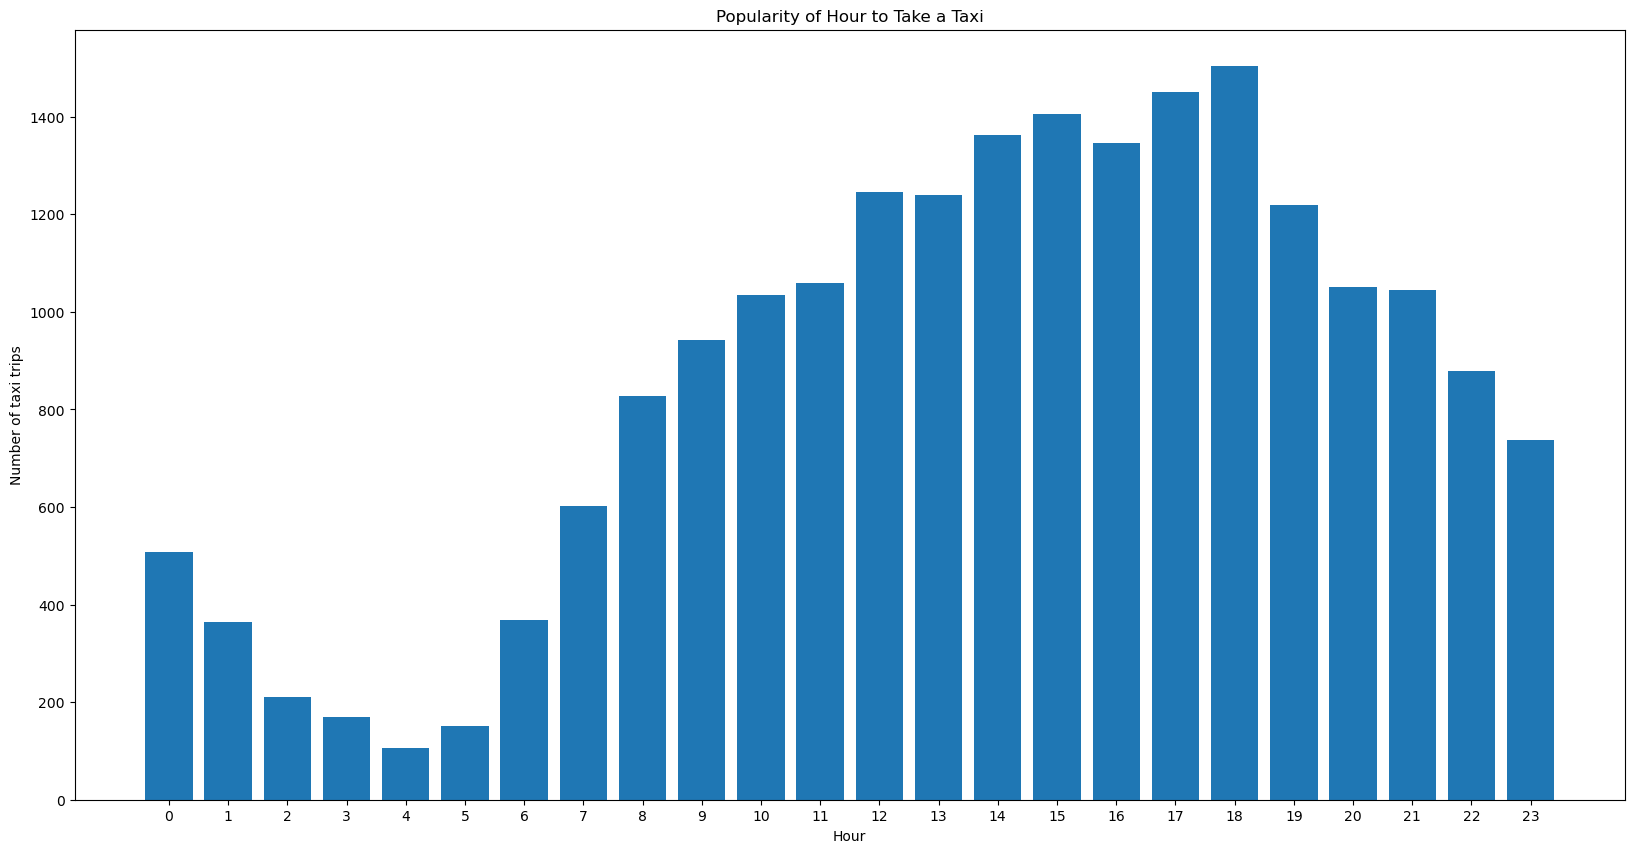

In [214]:
some_dataframe = get_data_for_popularity_of_hours()
plot_popularity_of_hours(some_dataframe)

### Explaination for the final result of Visualization 1:
The graph shows the popularity of hour to take a taxi. x-axis is the hours and y-axis is the number of taxi trips exist during that hour.
From 0 am to 6 am, the number of taxi trips are low, the reason is people are sleeping. Starting at 7 am, the number of trips gradually rises, and reach the paek at 6pm which may correspond to the off-duty peak. After 6PM, the number starts to decline steadily until 11 PM.

### Visualization 2：What’s the most popular month to hire a cab or Uber?

This graph shows the popularity of month for taking hired riders, based on the number of hired riders.

---

### **Step 1. Define function: plot_popularity_of_month(dataframe)**
- Draws the line chart. x-axis is month and y-axis is Average Distance Traveled per Month.
- Calculates the mean, the standard deviation and 90% confidence interval.
- Plots the confidence interval as a shaded region
### **Step 2. Define function: get_data_for_popularity_of_month()**
- The query retrieves data from the `TAXI` and `UBER` table.
- **Query Details**:
  - Extracts the month (`%Y-%m`) from the `tpep_pickup_datetime` and `pickup_datetime` column using `strftime()`.
  - Groups trips by month and calculate sum of the distances for each month.
### **Step 3. Run the function：get_data_for_popularity_of_month()**
- Runs the function：get_data_for_popularity_of_month(), ensuring the function work correctly.
### **Step 4. Run the function：plot_popularity_of_month(dataframe)**
- Runs the function: plot_popularity_of_month(dataframe) to see the result.

In [218]:
def plot_popularity_of_month(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    # Calculate the mean, the standard deviation and 90% confidence interval
    mean = dataframe['average_distance_traveled_per_month'].mean()
    std = dataframe['average_distance_traveled_per_month'].std()
    confidence_interval = 1.645 * (std / np.sqrt(56))
    
    # Plot the sum (combined total distance) per month
    axes.plot(dataframe['month'], dataframe['average_distance_traveled_per_month'], label = 'Average Distance Traveled per Month', marker='o')
    

    # Plot the confidence interval as a shaded region
    axes.fill_between(dataframe['month'], 
                      dataframe['average_distance_traveled_per_month'] - confidence_interval, 
                      dataframe['average_distance_traveled_per_month'] + confidence_interval, alpha = 0.2, label='90% Confidence Interval')
    

    # Set the title and x, y labels
    axes.set_title('Average Distance Traveled per Month with 90% Confidence Interval')
    axes.set_xlabel('Month')
    axes.set_ylabel('Average Distance Traveled per Month')
    axes.grid(True)
    
    # Make sure mark on the x-axis do not overlap with each other
    plt.xticks(rotation=45, ha='right')
    axes.legend(loc='upper right')

    plt.show()

In [220]:
def get_data_for_popularity_of_month():
    query = """
    SELECT strftime('%Y-%m', tpep_pickup_datetime) AS month, SUM(trip_distance) AS average_distance_traveled_per_month
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-30 23:59:59'
    GROUP BY month
    UNION ALL
    SELECT strftime('%Y-%m', pickup_datetime) AS month, SUM(trip_miles) AS average_distance_traveled_per_month
    FROM UBER
    WHERE pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-30 23:59:59'
    GROUP BY month;
    """

    # Execute query and load into pandas DataFrame
    data = pd.read_sql(query, con=engine)
    # Sum the distance travel by uber and taxi
    final = data.groupby('month')['average_distance_traveled_per_month'].sum().reset_index()
    return final

In [222]:
get_data_for_popularity_of_month()

,month,average_distance_traveled_per_month
0,2020-01,2531.131
1,2020-02,2702.254
2,2020-03,2671.675
3,2020-04,2522.971
4,2020-05,3113.848
5,2020-06,3045.795
6,2020-07,2837.015
7,2020-08,2678.792
8,2020-09,2578.688
9,2020-10,2606.930


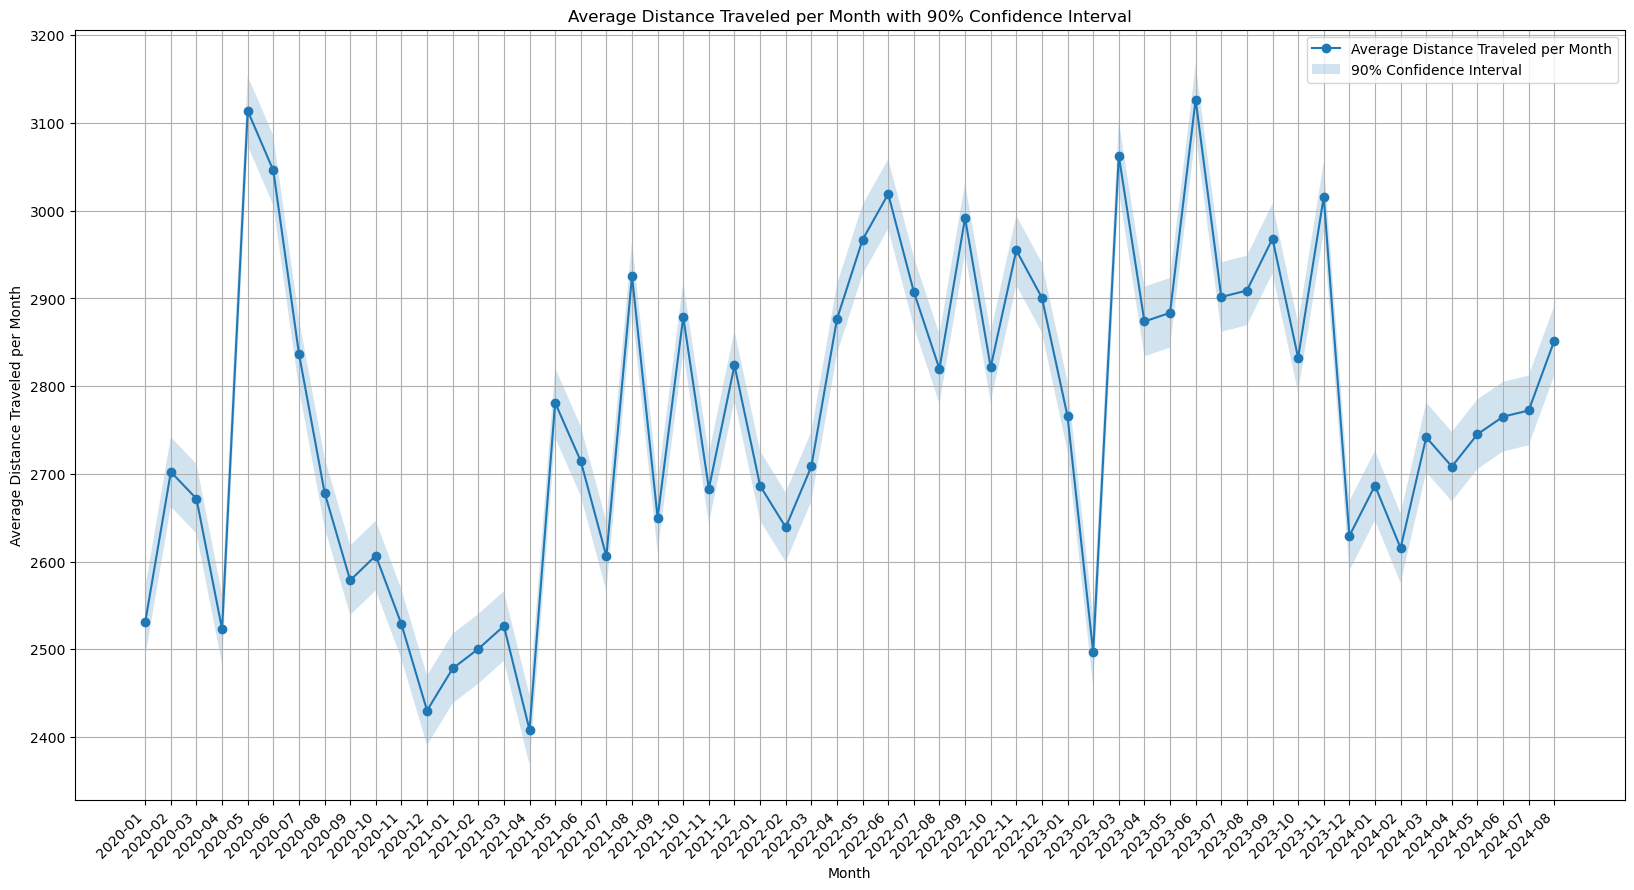

In [224]:
some_dataframe = get_data_for_popularity_of_month()
plot_popularity_of_month(some_dataframe)

### Explaination for the final result of Visualization 2:
The line chart shows average distances traveled per month with 90% confidence interval. x-axis is month and y-axis is average distance traveled per month. The blue shadow shows the 90% confidence interval. The numbers fluctuate significantly every month. The lowest point was in April 2021. The possible reason for that might be covid-19. The lowest point was in June 2023, and the potential reason might be tourist.

### Visualization 3.1：Which day of the week is most popular for taking a ride to LGA?

This graph shows the popularity of days of week for taking hired riders to LGA, based on the number of hired riders.

---

### **Step 1. Define function: plot_popularity_LGA(dataframe)**
- Draws the bar chart. x-axis is days and y-axis is the number of taxi trips exist during that day.
- Add the same weekday's taxi and uber by function .groupby() and .sum().
### **Step 2. Define function: get_data_for_popularity_LGA()**
- Extracts the day of the week (`%w`) from the `tpep_pickup_datetime` and `pickup_datetime` column using `strftime()`.
    - `0` = Sunday, `1` = Monday, ..., `6` = Saturday.
  - Limits dropoff_latitudes and dropoff_longitudes by LGA's coordinates.
  - Limits `tpep_pickup_datetime` and `pickup_datetime` from `2020-01-01` to `2024-8-31`.
  - Groups trips by day and counts the number of trips (`COUNT(*)`) for each day.
  - Orders the results in acscending order of (`day`).
### **Step 3. Run the function：get_data_for_popularity_LGA()**
- Runs the function：get_data_for_popularity_LGA(), ensuring the function work correctly.
### **Step 4. Run the function：plot_popularity_LGA(dataframe)**
- Runs the function: plot_popularity_LGA(dataframe) to see the result.

In [227]:
def plot_popularity_LGA(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    # Add the same weekday's taxi and uber
    data = dataframe.groupby('day')['day_num'].sum().reset_index()
    
    # Use the bar chart
    axes.bar(data['day'], data['day_num'])


    # Set the title and x, y labels
    axes.set_title("Popularity of Weekday to Hire Rides to LGA")
    axes.set_xlabel('Weekday')
    axes.set_ylabel('Number of Hired Rides')
    
    plt.show()

In [230]:
# Same as qurey 2, I use the strftime('%w', pickup_datetime) to take the day of the week.
# So 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday.
def get_data_for_popularity_LGA():
    query = """
    SELECT strftime('%w', tpep_pickup_datetime) AS day, COUNT(*) AS day_num
    FROM TAXI
    WHERE (dropoff_latitude BETWEEN 40.763589 AND 40.778865) AND (dropoff_longitude BETWEEN -73.891745 AND -73.854838)
    AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS day_num
    FROM UBER
    WHERE (dropoff_latitude BETWEEN 40.763589 AND 40.778865) AND (dropoff_longitude BETWEEN -73.891745 AND -73.854838)
    AND pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    ORDER BY 
    day;
    """
    
    data = pd.read_sql(query, con=engine)
    return data

In [232]:
get_data_for_popularity_LGA()

,day,day_num
0,0,25
1,0,38
2,1,29
3,1,37
4,2,31
5,2,56
6,3,33
7,3,43
8,4,37
9,4,51


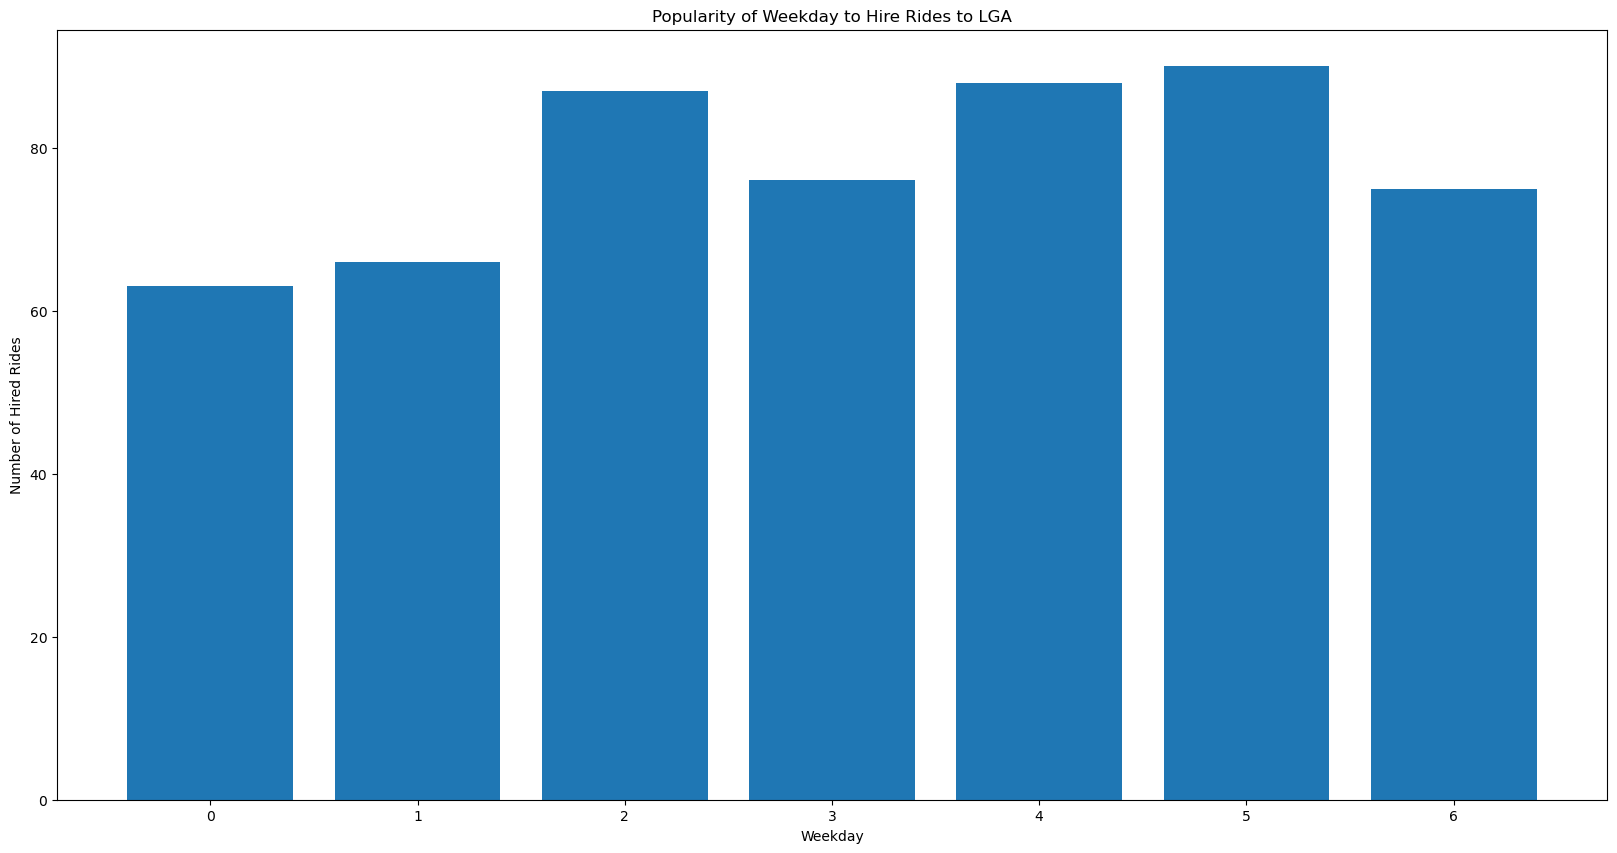

In [234]:
some_dataframe = get_data_for_popularity_LGA()
plot_popularity_LGA(some_dataframe)

### Explaination for the final result of Visualization 3.1:
The bar chart shows the popularity of weekday to hire rides to LGA. x-axis is days and y-axis is the number of taxi trips exist during that day. The numbers shows the weekdays, which 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday. From the graph, we can see that Tuseday, Thurday and Friday have relatively high numbers. These may caused by there are many people traveling for business in these three days.

### Visualization 3.2：Which day of the week is most popular for taking a ride to JFK?

This graph shows the popularity of days of week for taking hired riders to JFK, based on the number of hired riders.

---

### **Step 1. Define function: plot_popularity_JFK(dataframe)**
- Draws the bar chart. x-axis is days and y-axis is the number of taxi trips exist during that day.
- Add the same weekday's taxi and uber by function .groupby() and .sum().
### **Step 2. Define function: get_data_for_popularity_JFK()**
- Extracts the day of the week (`%w`) from the `tpep_pickup_datetime` and `pickup_datetime` column using `strftime()`.
    - `0` = Sunday, `1` = Monday, ..., `6` = Saturday.
  - Limits dropoff_latitudes and dropoff_longitudes by JFK's coordinates.
  - Limits `tpep_pickup_datetime` and `pickup_datetime` from `2020-01-01` to `2024-8-31`.
  - Groups trips by day and counts the number of trips (`COUNT(*)`) for each day.
  - Orders the results in acscending order of (`day`).
### **Step 3. Run the function：get_data_for_popularity_JFK()**
- Runs the function：get_data_for_popularity_JFK(), ensuring the function work correctly.
### **Step 4. Run the function：plot_popularity_JFK(dataframe)**
- Runs the function: plot_popularity_JFK(dataframe) to see the result.

In [238]:
def plot_popularity_JFK(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    # Add the same weekday's taxi and uber
    data = dataframe.groupby('day')['day_num'].sum().reset_index()
    
    # Use the bar chart
    axes.bar(data['day'], data['day_num'])


    # Set the title and x, y labels
    axes.set_title("Popularity of Weekday to Hire Rides to JFK")
    axes.set_xlabel('Weekday')
    axes.set_ylabel('Number of Hired Rides')
    
    plt.show()

In [240]:
# Same as qurey 2, I use the strftime('%w', pickup_datetime) to take the day of the week.
# So 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday.
def get_data_for_popularity_JFK():
    query = """
    SELECT strftime('%w', tpep_pickup_datetime) AS day, COUNT(*) AS day_num
    FROM TAXI
    WHERE (dropoff_latitude BETWEEN 40.763589 AND 40.778865) AND (dropoff_longitude BETWEEN -73.891745 AND -73.854838)
    AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS day_num
    FROM UBER
    WHERE (dropoff_latitude BETWEEN 40.639263 AND 40.651376) AND (dropoff_longitude BETWEEN -73.795642 AND -73.766264)
    AND pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    ORDER BY 
    day;
    """
    
    data = pd.read_sql(query, con=engine)
    return data

In [242]:
get_data_for_popularity_JFK()

,day,day_num
0,0,25
1,0,65
2,1,29
3,1,44
4,2,31
5,2,49
6,3,33
7,3,47
8,4,37
9,4,51


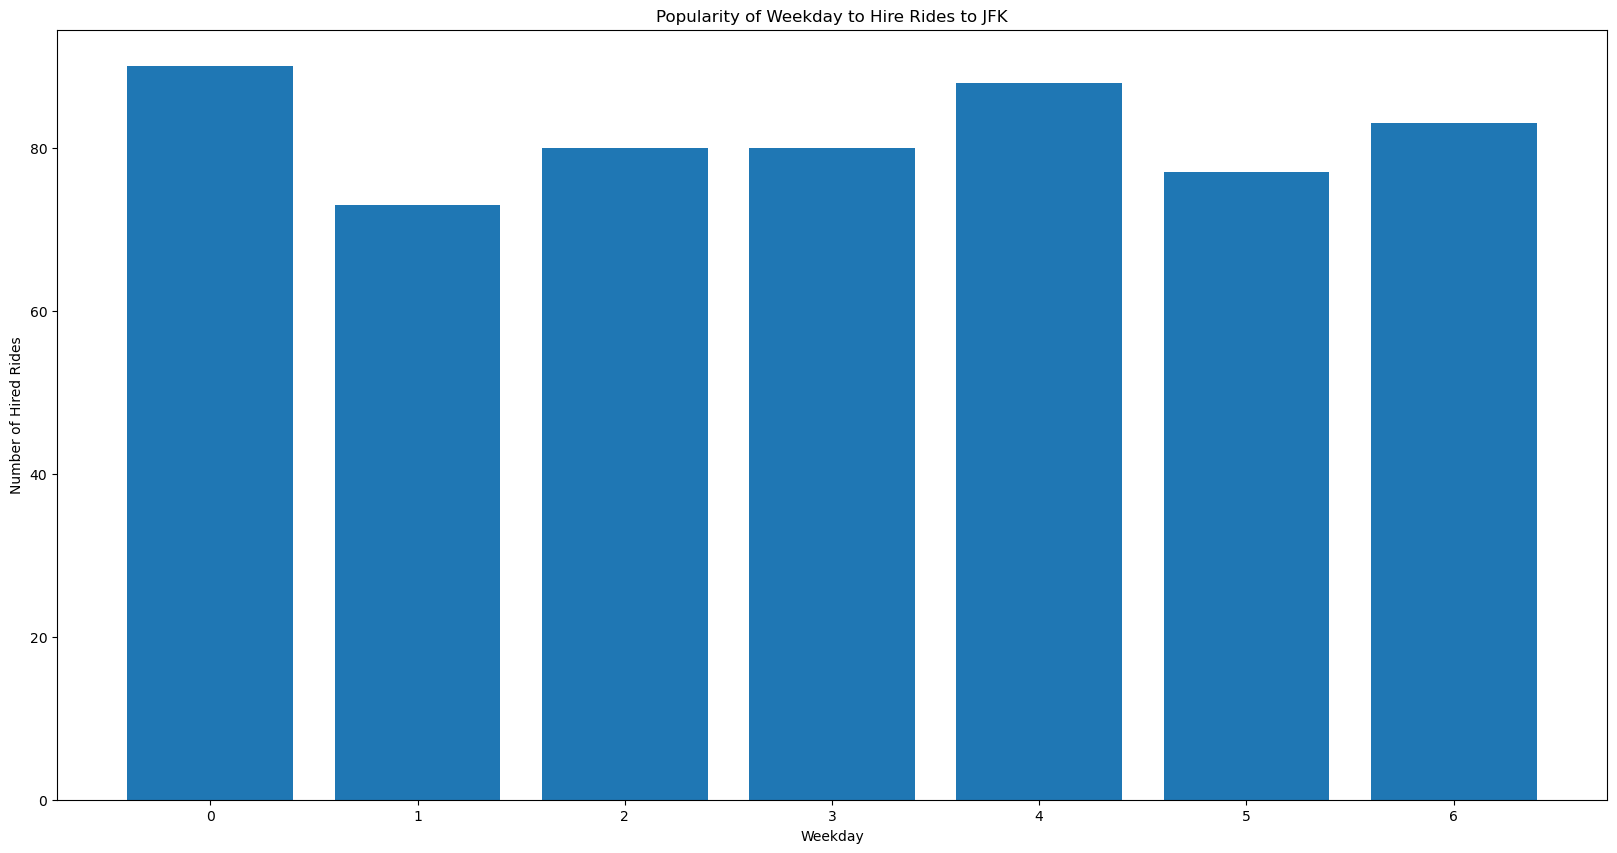

In [244]:
some_dataframe = get_data_for_popularity_JFK()
plot_popularity_JFK(some_dataframe)

### Explaination for the final result of Visualization 3.2:
The bar chart shows the popularity of weekday to hire rides to JFK. x-axis is days and y-axis is the number of taxi trips exist during that day. The numbers shows the weekdays, which 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday. From the graph, we can see that except for Sunday, the numbers to JFK do not change a lot. Sunday is the most popular day which is about 90.

### Visualization 3.3：Which day of the week is most popular for taking a ride to EWR?

This graph shows the popularity of days of week for taking hired riders to EWR, based on the number of hired riders.

---

### **Step 1. Define function: plot_popularity_EWR(dataframe)**
- Draws the bar chart. x-axis is days and y-axis is the number of taxi trips exist during that day.
- Add the same weekday's taxi and uber by function .groupby() and .sum().
### **Step 2. Define function: get_data_for_popularity_EWR()**
- Extracts the day of the week (`%w`) from the `tpep_pickup_datetime` and `pickup_datetime` column using `strftime()`.
    - `0` = Sunday, `1` = Monday, ..., `6` = Saturday.
  - Limits dropoff_latitudes and dropoff_longitudes by EWR's coordinates.
  - Limits `tpep_pickup_datetime` and `pickup_datetime` from `2020-01-01` to `2024-8-31`.
  - Groups trips by day and counts the number of trips (`COUNT(*)`) for each day.
  - Orders the results in acscending order of (`day`).
### **Step 3. Run the function：get_data_for_popularity_EWR()**
- Runs the function：get_data_for_popularity_EWR(), ensuring the function work correctly.
### **Step 4. Run the funtion：plot_popularity_EWR(dataframe)**
- Runs the function: plot_popularity_EWR(dataframe) to see the result.

In [248]:
def plot_popularity_EWR(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    # Add the same weekday's taxi and uber
    data = dataframe.groupby('day')['day_num'].sum().reset_index()
    
    # Use the bar chart
    axes.bar(data['day'], data['day_num'])


    # Set the title and x, y labels
    axes.set_title("Popularity of Weekday to Hire Rides to EWR")
    axes.set_xlabel('Weekday')
    axes.set_ylabel('Number of Hired Rides')
    
    plt.show()

In [250]:
# Same as qurey 2, I use the strftime('%w', pickup_datetime) to take the day of the week.
# So 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday.
def get_data_for_popularity_EWR():
    query = """
    SELECT strftime('%w', tpep_pickup_datetime) AS day, COUNT(*) AS day_num
    FROM TAXI
    WHERE (dropoff_latitude BETWEEN 40.763589 AND 40.778865) AND (dropoff_longitude BETWEEN -73.891745 AND -73.854838)
    AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    UNION ALL
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS day_num
    FROM UBER
    WHERE (dropoff_latitude BETWEEN 40.686794 AND 40.699680) AND (dropoff_longitude BETWEEN -74.194028 AND -74.165205)
    AND pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day
    
    ORDER BY 
    day;
    """
    
    data = pd.read_sql(query, con=engine)
    return data

In [252]:
get_data_for_popularity_EWR()

,day,day_num
0,0,25
1,0,13
2,1,29
3,1,11
4,2,31
5,2,19
6,3,33
7,3,19
8,4,37
9,4,22


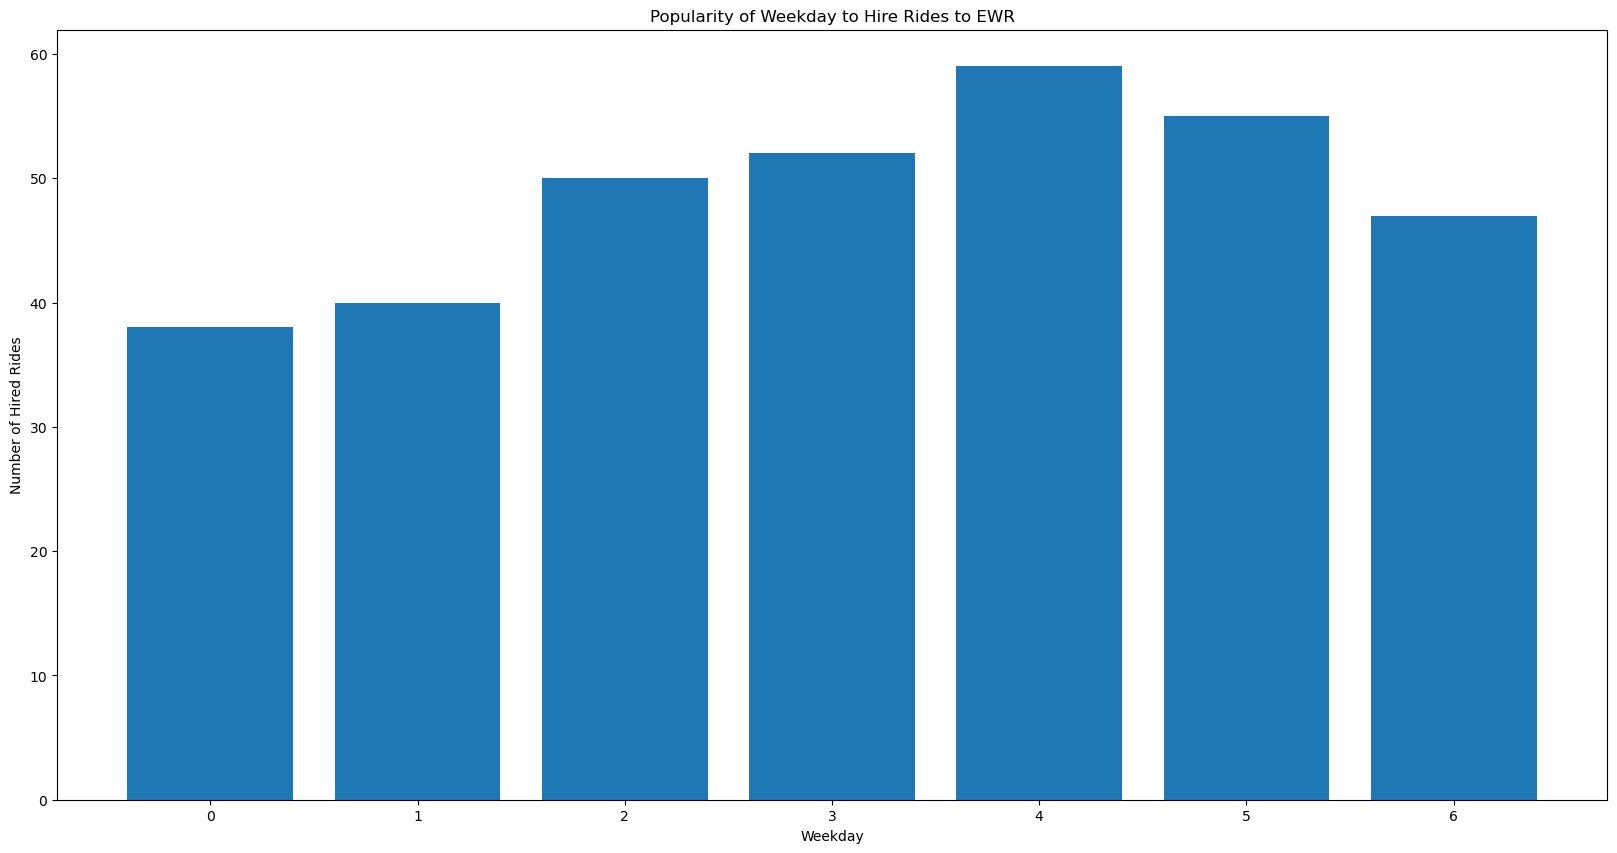

In [254]:
some_dataframe = get_data_for_popularity_EWR()
plot_popularity_EWR(some_dataframe)

### Explaination for the final result of Visualization 3.3:
The bar chart shows the popularity of weekday to hire rides to EWR. x-axis is days and y-axis is the number of taxi trips exist during that day. The numbers shows the weekdays, which 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday. The graph's trend shows an gentle increase from Sunday, then reaching a peak on Thursday, after that it starts to decline. The most popular day is Thurday and the number is about 60.

### Visualization 4.1: How much do yellow taxi earn in total fares monthly?

This graph compares the monthly earned total fares between January 2020 through August 2024 for Yellow Taxis. 

---

### **Step 1. Define function: plot_total_fares_taxi(dataframe)**
- Draws the bar chart. x-axis is months and y-axis is fares.
- Separate each bar into 2 parts: `base_fare` and `total_congestion_surcharge`.
- `base_fare` = `total_cost` - `tips`
### **Step 2. Define function: get_data_for_total_fares_taxi()**
  - Extracts the month (`%Y-%m`) from the `tpep_pickup_datetime` column using `strftime()`.
  - Groups `total_cost`, `tip_amount` and `congestion_surcharge` by month and calculate sum for each month.
### **Step 3. Run the function：get_data_for_total_fares_taxi()**
- Runs the function：get_data_for_total_fares_taxi(), ensuring the function work correctly.
### **Step 4. Run the function：plot_total_fares_taxi(dataframe)**
- Runs the function: plot_total_fares_taxi(dataframe) to see the result.

In [258]:
def plot_total_fares_taxi(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    # Plot Yellow Taxi data (for each component)
    axes.bar(some_dataframe['month'], some_dataframe['total_fare'] - some_dataframe['total_tips'], label='Base Fare', color='green')
    axes.bar(some_dataframe['month'], some_dataframe['total_congestion_surcharge'], bottom=some_dataframe['total_fare'] - some_dataframe['total_tips'], 
           label='Congestion Surcharge', color='orange')

    # Set titles and labels
    axes.set_title('Monthly TotalFares for Yellow Taxis')
    axes.set_xlabel('Month')
    axes.set_ylabel('Fares')
    axes.legend(loc='upper left')

    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [260]:
def get_data_for_total_fares_taxi():
    query_taxi = """
    SELECT 
        strftime('%Y-%m', tpep_pickup_datetime) AS month, 
        SUM(total_cost) AS total_fare,
        SUM(congestion_surcharge) AS total_congestion_surcharge,
        SUM(tip_amount) AS total_tips
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month;
    """

    data = pd.read_sql(query_taxi, con=engine)
    return data

In [262]:
get_data_for_total_fares_taxi()

,month,total_fare,total_congestion_surcharge,total_tips
0,2020-01,7951.21,860.0,841.02
1,2020-02,7879.11,895.0,861.03
2,2020-03,7593.52,842.5,707.12
3,2020-04,5836.04,742.5,527.42
4,2020-05,5985.47,637.5,594.53
5,2020-06,6252.70,697.5,655.50
6,2020-07,6466.92,732.5,648.61
7,2020-08,6362.42,745.0,654.90
8,2020-09,6400.52,745.0,683.41
9,2020-10,6708.13,820.0,791.50


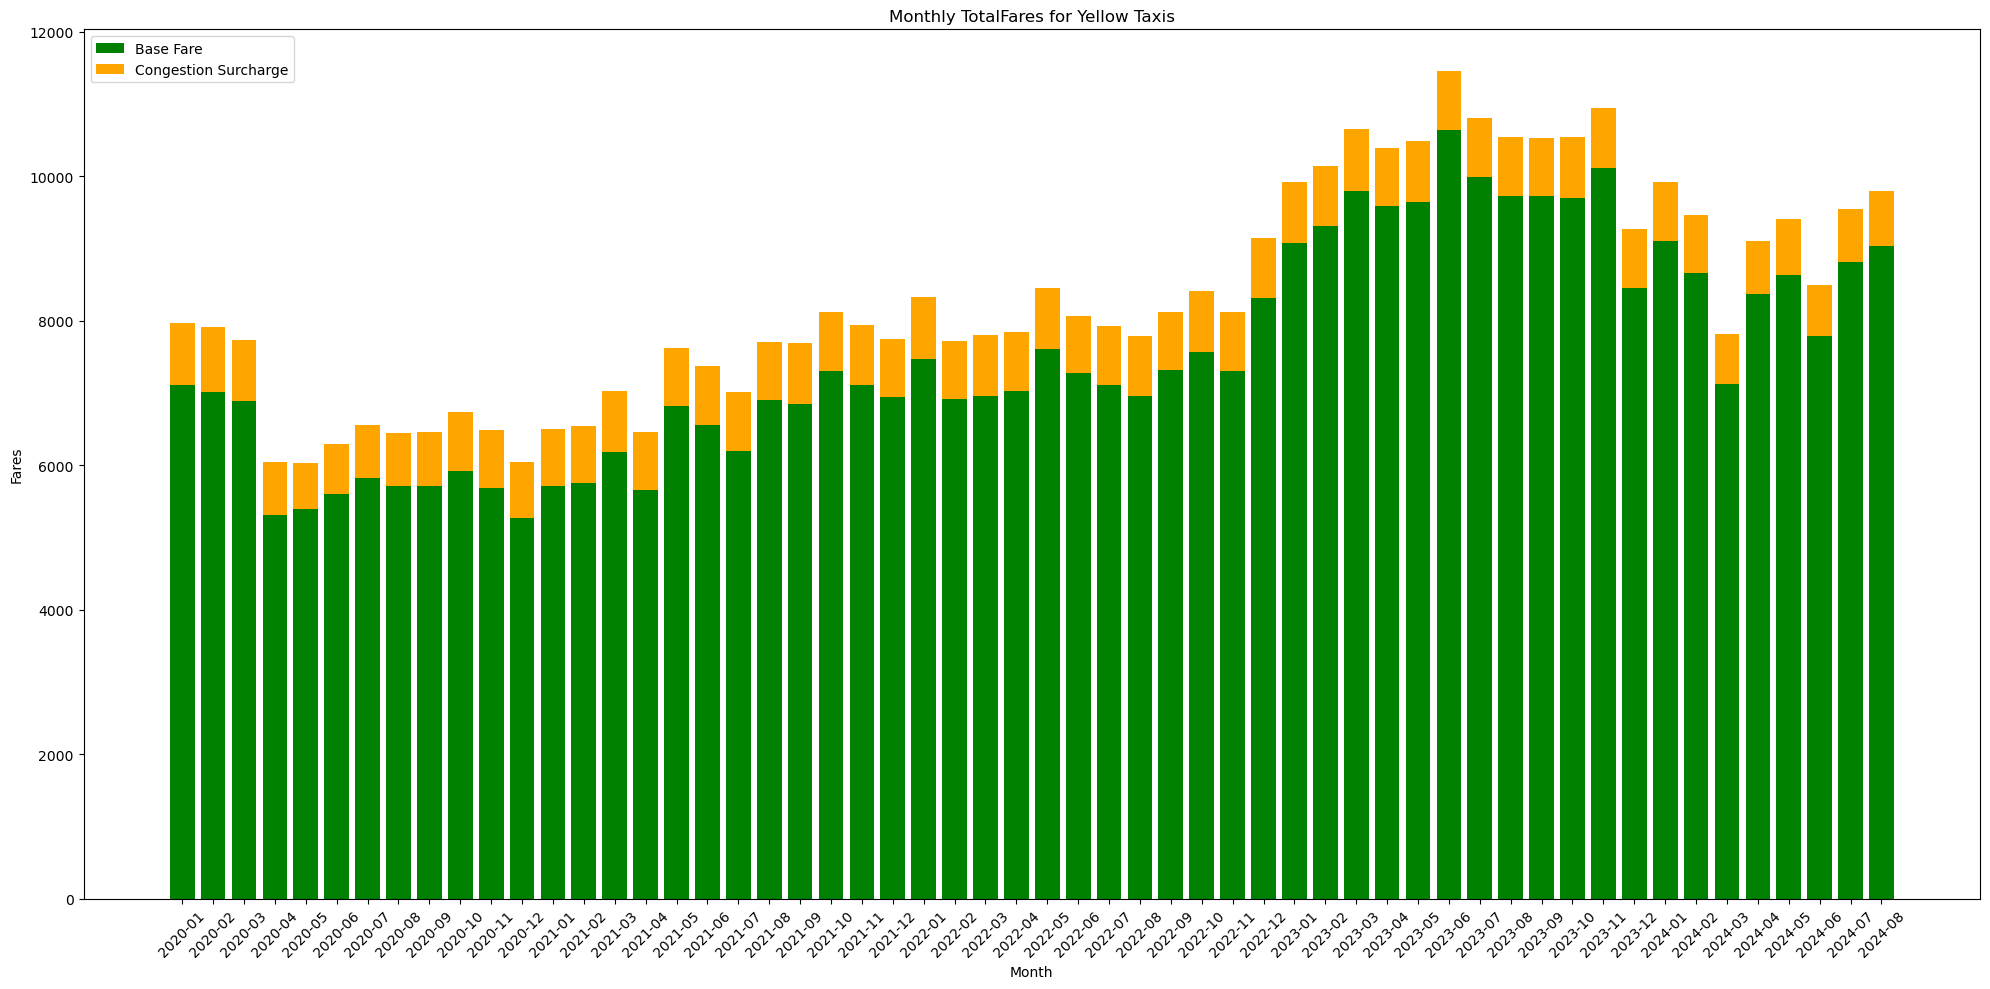

In [264]:
some_dataframe = get_data_for_total_fares_taxi() 
plot_total_fares_taxi(some_dataframe) 

### Explaination for the final result of Visualization 4.1:
The bar chart shows the monthly total fares for yellow taxi. x-axis is months and y-axis is fares. The green parts display the base fares and orange parts is congestion surcharge. Congestion surcharge was stable over the years. From the chart, we can see that the fares in 2023 are significantly higher than previous years, this may caused by inflation after the convid-19.

### Visualization 4.2: How much do uber earn in total fares monthly?

This graph compares the monthly earned total fares between January 2020 through August 2024 for Uber. 

---

### **Step 1. Define function: plot_total_fares_uber(dataframe)**
- Draws the bar chart x-axis is months and y-axis is fares.
- Separate each bar into 4 parts: `base_fare`, `total_congestion_surcharge`, `total_sales_tax`, `total_tolls`.
### **Step 2. Define function: get_data_for_total_fares_uber()**
  - Extracts the month (`%Y-%m`) from the `pickup_datetime` column using `strftime()`.
  - Groups `base_fare`, `total_congestion_surcharge`, `total_sales_tax`, `total_tolls` by month and calculate sum for each month.
### **Step 3. Run the function：get_data_for_total_fares_uber()**
- Runs the function：get_data_for_total_fares_uber(), ensuring the function work correctly.
### **Step 4. Run the function：plot_total_fares_uber(dataframe)**
- Runs the function: plot_total_fares_uber(dataframe) to see the result.

In [268]:
def plot_total_fares_uber(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    # Plot Uber data (for each component)
    axes.bar(some_dataframe['month'], some_dataframe['base_fare'], label='Base Fare', color='green')
    axes.bar(some_dataframe['month'], some_dataframe['total_congestion_surcharge'], bottom=some_dataframe['base_fare'], 
           label='Congestion Surcharge', color='orange')
    axes.bar(some_dataframe['month'], some_dataframe['total_sales_tax'], bottom=some_dataframe['base_fare'] + some_dataframe['total_congestion_surcharge'],
           label='Sales Tax', color='red')
    axes.bar(some_dataframe['month'], some_dataframe['total_tolls'], bottom=some_dataframe['base_fare'] + some_dataframe['total_congestion_surcharge'] + some_dataframe['total_sales_tax'],
           label='Tolls', color='purple')

    # Set titles and labels
    axes.set_title('Monthly Total Fares for Uber')
    axes.set_xlabel('Month')
    axes.set_ylabel('Fares')
    axes.legend(loc='upper left')

    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [270]:
def get_data_for_total_fares_uber():
    query_taxi = """
    SELECT
        strftime('%Y-%m', pickup_datetime) AS month, 
        SUM(base_passenger_fare) AS base_fare,
        SUM(congestion_surcharge) AS total_congestion_surcharge,
        SUM(sales_tax) AS total_sales_tax,
        SUM(tolls) AS total_tolls
    FROM UBER
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month;
    """

    data = pd.read_sql(query_taxi, con=engine)
    return data

In [272]:
get_data_for_total_fares_uber()

,month,base_fare,total_congestion_surcharge,total_sales_tax,total_tolls
0,2020-01,5445.14,360.50,478.34,198.15
1,2020-02,5966.46,403.25,524.72,192.94
2,2020-03,5469.65,321.50,487.31,190.75
3,2020-04,5625.64,192.50,500.49,83.72
4,2020-05,6316.25,250.25,559.94,178.39
5,2020-06,7038.39,255.75,608.45,251.53
6,2020-07,7118.50,280.50,622.40,155.65
7,2020-08,6221.26,310.75,553.42,222.87
8,2020-09,6141.98,352.00,552.69,164.88
9,2020-10,6300.82,357.50,544.45,196.39


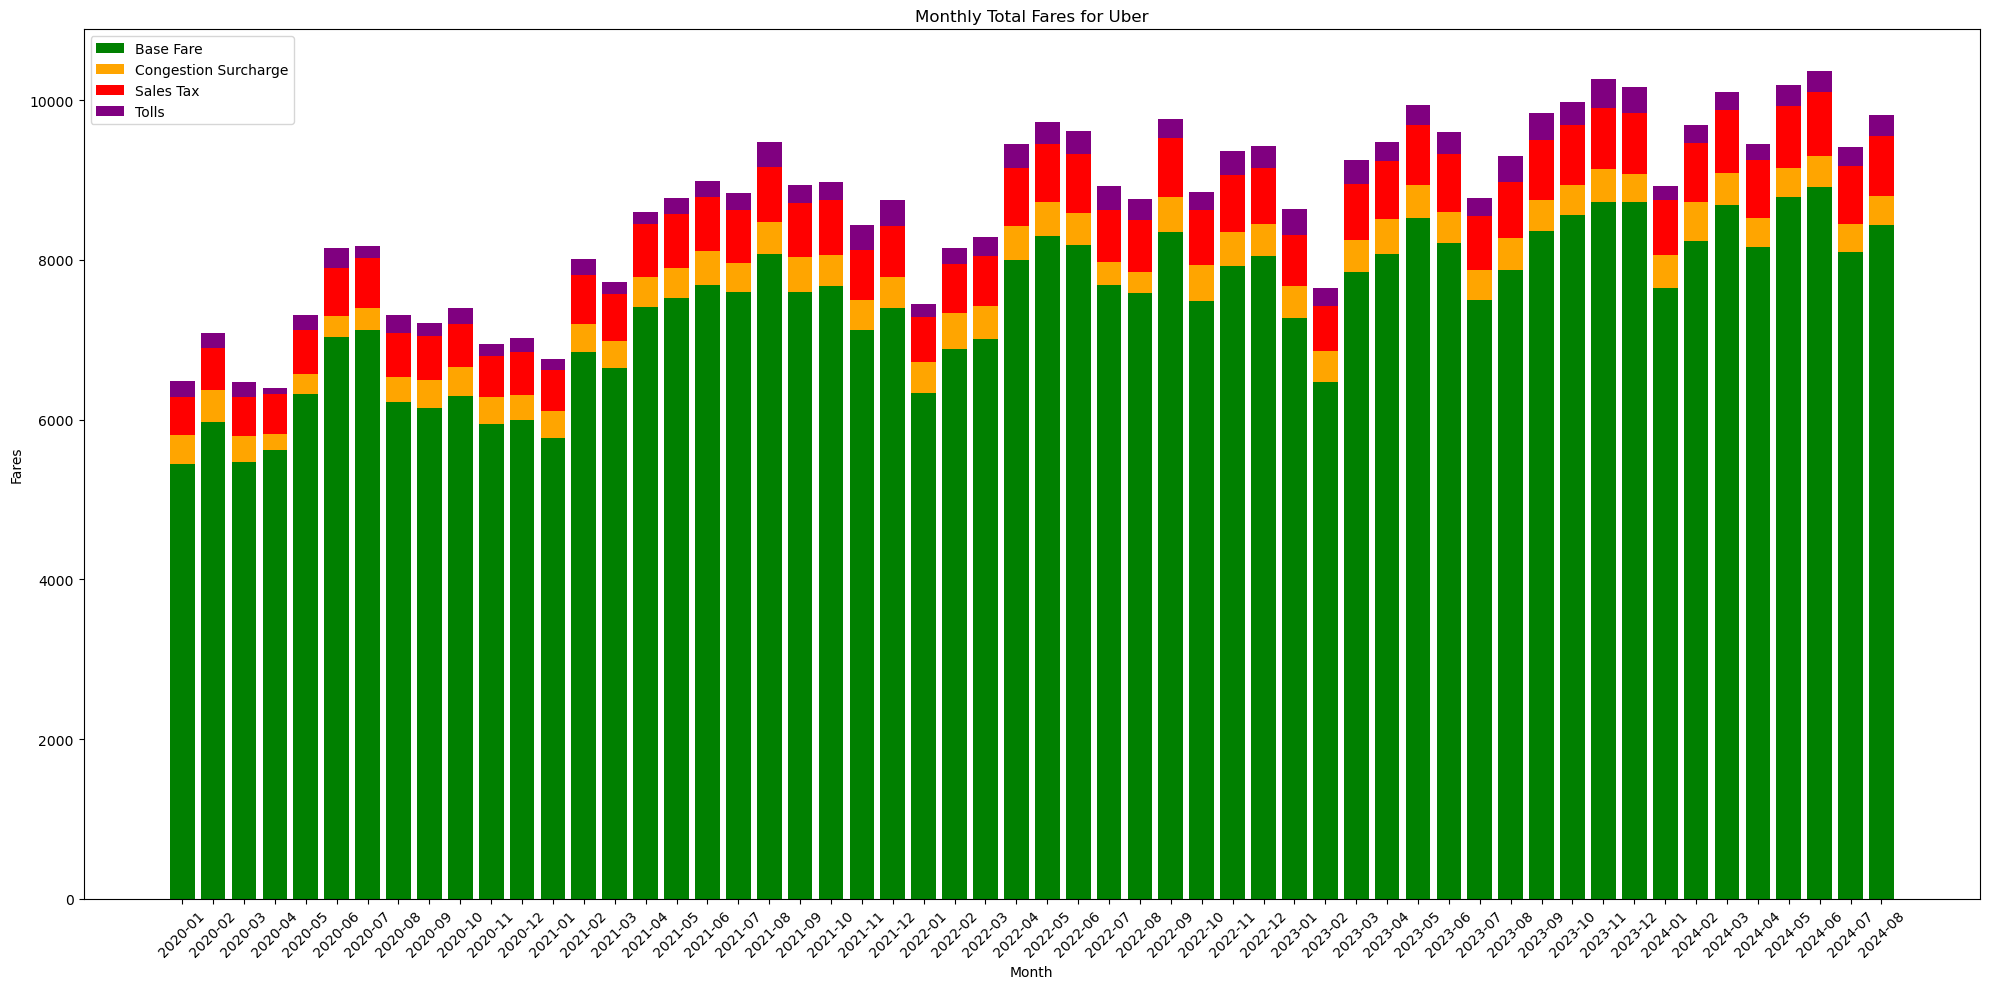

In [274]:
some_dataframe = get_data_for_total_fares_uber()
plot_total_fares_uber(some_dataframe)

### Explaination for the final result of Visualization 4.2:
The bar chart shows the monthly total fares for uber. x-axis is months and y-axis is fares. The green parts display the base fares, orange parts is congestion surcharge, red part is sales tax and purple part is tolls. From the chart, we can see that the fares of congestion surcharge, sales tax and tolls were stable over the years. Change in total fares were mainly caused by base fare.

### Visualization 5: Does precipitation or distance traveled affect the amount of tip?

This graphcreates 4 scatter plots for the year 2022-2023, each one comparing amount of tip versus: distance for Yellow Taxi rides, distance for Uber ride, precipitation for Yellow Taxi ride, precipitation for Uber rides.

---

### **Step 1. Define function: plot_scatter_plots_tip(dataframe)**
- Draws the scatter plots x-axis is one of 4 factors and y-axis is tips.
- Remove rows where tips, distance, Hourly_Precipitation is na or 0.
### **Step 2. Define function: get_data_for_scatter_plots_tip()**
  - Extracts the month (`%Y-%m-%d %H`) from the `tpep_pickup_datetime`, `pickup_datetime`, `DATE` column using `strftime()`.
  - Groups `trip_distance`, `tip_amount`, `yips`, `trip_miles`, `HourlyPrecipitation` by date.
### **Step 3. Run the function：get_data_for_scatter_plots_tip()**
- Runs the function：get_data_for_scatter_plots_tip(), ensuring the function work correctly.
### **Step 4. Run the function：plot_scatter_plots_tip(dataframe)**
- Runs the function: plot_scatter_plots_tip(dataframe) to see the result.

In [278]:
def plot_scatter_plots_tip(dataframe):

    # Get a copy for dataframe.
    # This ensures that when removing point Hourly_Precipitation = 0, do not influence the distance point.
    dataframe_1 = dataframe.copy()

    # Maker sure the column of Hourly_Precipitation is numerical ensure it will not raise a error when drwaing the graph.
    dataframe_1['Hourly_Precipitation'] = pd.to_numeric(dataframe_1['Hourly_Precipitation'], errors='coerce')
    
    # Remove rows where tips, distance is na.
    dataframe = dataframe.dropna(subset=['tips', 'distance'])
    
    # Remove rows where tips, Hourly_Precipitation is na.
    dataframe_1 = dataframe_1.dropna(subset=['tips', 'Hourly_Precipitation'])

    # Remove points if tips = 0
    dataframe = dataframe[(dataframe['tips'] != 0)]
    dataframe_1 = dataframe_1[(dataframe_1['tips'] != 0)]
    
    # Remove points if distance = 0
    dataframe = dataframe[(dataframe['distance'] != 0)]
    
    # Remove points if Hourly_Precipitation = 0
    dataframe = dataframe[(dataframe['Hourly_Precipitation'] != 0)]
    
    # Create a 2x2 subplot layout
    figure, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # Graph 1: Taxi: Tips vs Distance
    taxi_data = dataframe[dataframe['type'] == 'Taxi']
    axes[0, 0].scatter(taxi_data['distance'], taxi_data['tips'], color = 'green', s = 15)
    axes[0, 0].set_title('Taxi: Tips vs. Distance')
    axes[0, 0].set_xlabel('Distance')
    axes[0, 0].set_ylabel('Tips')
    
    # Graph 2: Uber: Tips vs Distance
    uber_data = dataframe[dataframe['type'] == 'Uber']
    axes[0, 1].scatter(uber_data['distance'], uber_data['tips'], color = 'orange', s = 15)
    axes[0, 1].set_title('Uber: Tips vs. Distance')
    axes[0, 1].set_xlabel('Distance')
    axes[0, 1].set_ylabel('Tips')

    # Graph 3: Taxi: Tips vs Precipitation
    taxi_data_1 = dataframe_1[dataframe_1['type'] == 'Taxi']
    axes[1, 0].scatter(taxi_data_1['Hourly_Precipitation'], taxi_data_1['tips'], color = 'red', s = 15)
    axes[1, 0].set_title('Taxi: Tip vs. Precipitation')
    axes[1, 0].set_xlabel('Precipitation')
    axes[1, 0].set_ylabel('Tips')
    
    # Graph 3: Uber: Tips vs. Precipitation
    uber_data_1 = dataframe_1[dataframe_1['type'] == 'Uber']
    axes[1, 1].scatter(uber_data_1['Hourly_Precipitation'], uber_data_1['tips'], color = 'purple', s = 15)
    axes[1, 1].set_title('Uber: Tips vs. Precipitation')
    axes[1, 1].set_xlabel('Precipitation')
    axes[1, 1].set_ylabel('Tips')

    plt.show()


In [280]:
def get_data_for_scatter_plots_tip():
    query = """
    WITH HiredRiders AS (
    SELECT
        strftime('%Y-%m-%d %H', tpep_pickup_datetime) AS date,
        trip_distance AS distance, 
        tip_amount AS tips,
        'Taxi' AS type
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2022-01-01 00:00:00' AND '2023-12-31 23:59:59'

    UNION ALL

    SELECT 
        strftime('%Y-%m-%d %H', pickup_datetime) AS date,
        trip_miles AS distance,
        tips AS tips,
        'Uber' AS type
    FROM UBER
    WHERE pickup_datetime BETWEEN '2022-01-01 00:00:00' AND '2023-12-31 23:59:59'
    GROUP BY date
    ),
    Weather AS (
    SELECT 
        strftime('%Y-%m-%d %H', DATE) AS date,
        HourlyPrecipitation AS Hourly_Precipitation
    FROM HOURLY_WEATHER
    WHERE Date BETWEEN '2022-01-01 00:00:00' AND '2023-12-31 23:59:59'
    GROUP BY date
    )
    SELECT 
        HiredRiders.date AS date,                
        HiredRiders.distance AS distance,
        HiredRiders.type AS type,
        HiredRiders.tips AS tips,
        Weather.Hourly_Precipitation                  
    FROM HiredRiders
    LEFT JOIN Weather ON HiredRiders.date = Weather.date
    ORDER BY HiredRiders.date;
        """

    data = pd.read_sql(query, con=engine)
    return data

In [282]:
get_data_for_scatter_plots_tip()

,date,distance,type,tips,Hourly_Precipitation
0,2022-01-01 01,1.90,Taxi,4.40,0.0
1,2022-01-01 01,2.41,Taxi,3.56,0.0
2,2022-01-01 02,2.00,Taxi,0.00,0.0
3,2022-01-01 02,2.00,Taxi,0.00,0.0
4,2022-01-01 02,2.00,Taxi,0.00,0.0
...,...,...,...,...,...
20586,2023-12-31 21,1.31,Taxi,2.72,None
20587,2023-12-31 22,0.56,Taxi,0.00,None
20588,2023-12-31 22,7.87,Uber,0.00,None
20589,2023-12-31 23,2.94,Taxi,4.26,None


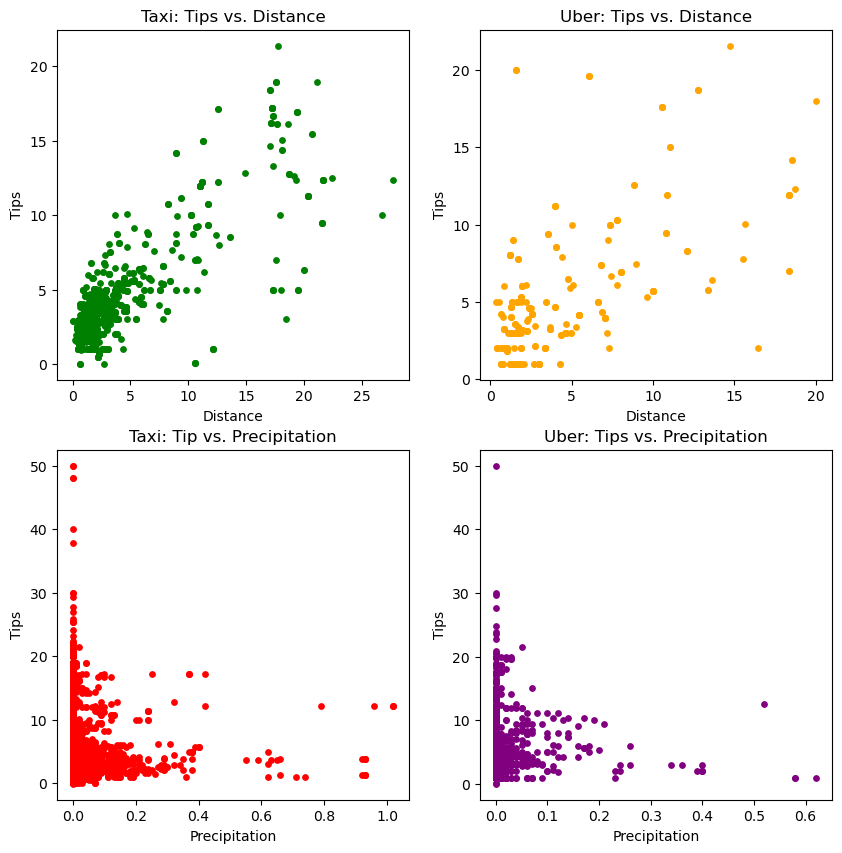

In [283]:
some_dataframe = get_data_for_scatter_plots_tip()
plot_scatter_plots_tip(some_dataframe)

### Explaination for the final result of Visualization 5:
This graph consist of 4 scatter plots for the year 2022-2023, each one comparing amount of tip versus: distance for Yellow Taxi rides, distance for Uber ride, precipitation for Yellow Taxi ride, precipitation for Uber rides. x-axis is one of 4 factors and y-axis is tips.The first two charts show that tips and distance are proportional to each other. The rest two charts tell us that when it has rain people are more likely to give tips than usual, but it do not show the relationship between the amount of precipitation and tips. It tends to be random.

### Visualization 6: 
Create a heatmap of all hired trips in 2020 over a map of the area.

---

### **Step 1. Define function: plot_heatmap(dataframe)**
- Draws the heatmap for New York, map center is the center of New York.
### **Step 2. Define function: get_data_for_scatter_plots_tip()**
  - Groups `dropoff_latitude` and `dropoff_longitude` by datetime for both taxi and uber, then join the table.
### **Step 3. Run the function：get_data_for_heatmap()**
- Runs the function：get_data_for_heatmap(), ensuring the function work correctly.
### **Step 4. Run the function：plot_heatmap(dataframe)**
- Runs the function: plot_heatmap(dataframe) to see the result.

In [287]:
import folium
from folium.plugins import HeatMap

In [289]:
def plot_heatmap(dataframe):

    NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
    New_York = [(40.560445 + 40.908524)/2, (-74.242330 + -73.717047)/2]

    # Set suitable zoom level which for city
    heat_map = folium.Map(location = New_York, zoom_start = 12)

    # Drop na
    locations = dataframe[['latitude', 'longitude']].dropna()

    # Add point to map
    heat_data = [[row['latitude'], row['longitude']] for index, row in locations.iterrows()]
    HeatMap(heat_data).add_to(heat_map)

    return heat_map

In [290]:
def get_data_for_heatmap():
    
    query = """
    SELECT dropoff_latitude AS latitude, dropoff_longitude AS longitude
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2020-12-31 23:59:59'
    UNION ALL
    SELECT dropoff_latitude AS latitude, dropoff_longitude AS longitude
    FROM UBER
    WHERE pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2020-12-31 23:59:59';
    """

    data = pd.read_sql(query, con=engine)
    return data

In [294]:
get_data_for_heatmap()

,latitude,longitude
0,40.809457,-73.961764
1,40.748575,-73.985156
2,40.782478,-73.965554
3,40.775932,-73.946510
4,40.758028,-73.977698
...,...,...
8862,40.588403,-73.981431
8863,40.778766,-73.951010
8864,40.823319,-73.823540
8865,40.841709,-73.941399


In [296]:
some_dataframe = get_data_for_heatmap()
plot_heatmap(some_dataframe)

### Explaination for the final result of Visualization 6:
This graph is the heatmap for New York, map center is the center of New York. It is a heatmap for all hired trips in New York in 2020. The redder areas indicate a higher number of hired rides. From the chart, we can clearly see that Manhattan is the reddest area which means it has highest number of hired rides. In Manhattan, Midtown and Downtown are the reddest areas because there are a large number of workers and tourists.

In [299]:
pip freeze

aext-assistant @ file:///C:/b/abs_7e0qjcige6/croot/aext-assistant_1717062202219/workNote: you may need to restart the kernel to use updated packages.

aext-assistant-server @ file:///C:/b/abs_261y2c9vsm/croot/aext-assistant-server_1717060019302/work
aext-core @ file:///C:/b/abs_1e882xlg8y/croot/aext-core_1717056431204/work
aext-core-server @ file:///C:/b/abs_24av6ljtvu/croot/aext-core-server_1717075079138/work
aext-panels @ file:///C:/b/abs_44bc4hv663/croot/aext-panels_1717062218055/work
aext-panels-server @ file:///C:/b/abs_7f9_48fhp3/croot/aext-panels-server_1717060738001/work
aext-share-notebook @ file:///C:/b/abs_4bhc14ko2x/croot/aext-share-notebook_1717059348177/work
aext-share-notebook-server @ file:///C:/b/abs_2b3c16a8t0/croot/aext-share-notebook-server_1717057990383/work
aext-shared @ file:///C:/b/abs_1ex0tj8g9m/croot/aext-shared_1716991146845/work
aiobotocore @ file:///C:/b/abs_a0zxrsvpwx/croot/aiobotocore_1714464454692/work
aiohttp @ file:///C:/b/abs_8860tt1424/croot/aiohttp_

In [300]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [301]:
gitignore_content = """

# Cache files
__pycache__/
*.py[cod]

# Jupyter Notebook checkpoints
.ipynb_checkpoints/

# Ignore data files
*.csv
*.parquet
*.sqlite
*.db

# Ignore virtual environments
.env
.venv/
*.log

# Ignore common shapefile extensions
*.xml
*.dbf
*.prj
*.shp
*.shx
*.sbn
*.sbx

# Ignore images
*.png
*.jpg

*.idea/
.vscode/
.DS_Store
"""

with open(".gitignore", "w") as file:
    file.write(gitignore_content)

#### **4. Sun Trips Table**
Stores uber trip data including sunrise and sunset.

In [303]:
sun_SCHEMA = """
CREATE TABLE IF NOT EXISTS SUN (
   sunId INTEGER PRIMARY KEY AUTOINCREMENT,
   DATE TEXT,
   Sunrise REAL,
   Sunset REAL
);

"""

In [304]:
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(sun_SCHEMA)

### Insert Data

In [306]:
# Remove the empty data and filled with  which can help us insert it easier
weather_data = pd.read_csv(r"C:\Users\wenji\OneDrive\Project\CleanWeather_data.csv")
cleaned_sun_data = weather_data[
    (weather_data["Sunrise"].notna()) &
    (weather_data["Sunset"].notna()) &
    (weather_data["Sunrise"] != 0) &
    (weather_data["Sunset"] != 0)
]
print(cleaned_sun_data.head())
# Insert
sun_columns = ['DATE', 'Sunrise', 'Sunset']
sun_weather_data = cleaned_sun_data[sun_columns]
sun_weather_data.to_sql('SUN', con=engine, if_exists='append', index=False)

                    DATE HourlyPrecipitation  HourlyWindSpeed DailySnowfall  \
24   2020-01-01T23:59:00                 NaN              NaN           0.0   
49   2020-01-02T23:59:00                 NaN              NaN           0.0   
86   2020-01-03T23:59:00                 NaN              NaN           0.0   
144  2020-01-04T23:59:00                 NaN              NaN           0.0   
169  2020-01-05T23:59:00                 NaN              NaN           0.0   

     DailyAverageWindSpeed DailyPrecipitation  Sunrise  Sunset  
24                     8.6               0.00    720.0  1639.0  
49                     5.4               0.00    720.0  1640.0  
86                     3.4               0.15    720.0  1641.0  
144                    4.4               0.27    720.0  1642.0  
169                   11.3                  T    720.0  1643.0  


1755

### Question: Get the table: number taxi hired and length of day for 2020-01

In [309]:
query_7 = """
WITH length_of_day AS (
    SELECT strftime('%Y-%m-%d', DATE) AS date, (Sunset - Sunrise) AS length
    FROM SUN
    WHERE DATE BETWEEN '2020-01-01' AND '2020-01-31'
    GROUP BY date
    ),
    TAXI_1 AS (
    SELECT strftime('%Y-%m-%d', tpep_pickup_datetime) AS date, COUNT(*) AS taxi_num
    FROM TAXI
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2020-01-31 23:59:59'
    GROUP BY date
    )
    SELECT length_of_day.DATE, length_of_day.length, TAXI_1.taxi_num
    FROM length_of_day
    LEFT JOIN TAXI_1 
    ON length_of_day.date = TAXI_1.date
    GROUP BY length_of_day.date;
    """


In [310]:
pd.read_sql(query_7, con=engine)

,date,length,taxi_num
0,2020-01-01,0.0,14
1,2020-01-02,0.0,9
2,2020-01-03,0.0,9
3,2020-01-04,0.0,13
4,2020-01-05,0.0,9
5,2020-01-06,0.0,9
6,2020-01-07,0.0,11
7,2020-01-08,0.0,10
8,2020-01-09,0.0,13
9,2020-01-10,0.0,15
